What now?

We create two tables with the following data:

# Table 1
- Based on basic data in `~/data/trd/crosses_info.csv`, we want to know 
    - number of loci with
        - TRD
        - of these
            - positive, negative outlier
                - pi
                - fst
                - dxy
                - LD
                - local phylogeny data
                - dn/ds
            - SVs
                - for each SV type, count of loci that overlap with these
            - repetitive elements
                - % region in rep. bp

# Table 2
- All individual TRD loci data, with per locus
    - percentile values for
        - pi
        - fst
        - dxy
        - LD
        - local phylogeny data
        - dn/ds
    - SVs, each type
        - % of loci overlapping with called SV
    - rep elements, each type
        - % locus


# Analysis

And then we look at 

- global distributions of values at TRD locus to find overall trends
- categorizing different types of TRD
- indivdiaul loci in detail by making RMarkdown HTMLs

In [418]:
library(tidytable)

In [419]:
# merge data from the different analysis to a per-TRD-locus table

# local phylogeny

LP_file<-"/home/jnrunge/data/trd/local_phylogenies_trd_analysis/TRD_regions_with_LP_data.csv.gz"
One_Table<-fread(LP_file)


# SVs

SV_files<-list.files("/home/jnrunge/data/trd/SV_analysis",
                    "SV_data.RDS$", full.names=TRUE)
SV_data<-data.table()
for(f in SV_files){
    SV_data<-bind_rows(SV_data, readRDS(f))
}

All_TYPE_source_combinations<-select(SV_data, TYPE, source)%>%distinct()


# not needed
#for(ci in unique(paste0(pull(SV_data, cross), "_",
#                      pull(SV_data, ID)))){
#    SV_data_sub<-filter(SV_data, paste0(cross,"_",ID)==ci)
#    
#    SV_data_sub_TYPE_source<-select(SV_data_sub, TYPE, source)%>%distinct()
#    
#    missing_TYPE_source<-anti_join(All_TYPE_source_combinations, SV_data_sub_TYPE_source)
#    
#    new_rows<-mutate(missing_TYPE_source, cross=strsplit(ci,"_",fixed=TRUE)[[1]][1],
#                    ID=strsplit(ci,"_",fixed=TRUE)[[1]][2], LEN_rel=0)
#    
#    SV_data<-bind_rows(SV_data, new_rows)
#    
#    stop("Never tested but ought to make sure there are no NA combinations unless the entire thing was not looked at")
#    
#}


SV_data_summary<-SV_data%>%filter(!is.na(TYPE))%>%
group_by(cross,ID,TYPE,source)%>%summarize(sum_LEN_rel=sum(LEN_rel))

head(SV_data_summary)

`summarise()` has grouped output by 'cross', 'ID', 'TYPE'. You can override using the `.groups` argument.


cross,ID,TYPE,source,sum_LEN_rel
<chr>,<int>,<chr>,<chr>,<dbl>
ChrisC4,2,CPG,Syri,0.0002838751
ChrisC4,2,CPL,Syri,0.0021584739
ChrisC4,2,DEL,Syri,0.0015319027
ChrisC4,2,DEL,VictorSV,0.0144085807
ChrisC4,2,DUP,Syri,0.0073679661
ChrisC4,2,DUP,VictorSV,0.0012480276


In [420]:
head(One_Table)

ID,lengthSNPs,chr,global_start,global_end,lengthBp,cross,start,end,PCA_eucldist_quantile_1,PCA_eucldist_sd_multiplier_1,IBS_eucldist_quantile_1,IBS_eucldist_sd_multiplier_1,tree_changes_quantile,tree_changes_sd_multiplier,tree_changes_raw,PCA_eucldist_quantile_2,PCA_eucldist_sd_multiplier_2,IBS_eucldist_quantile_2,IBS_eucldist_sd_multiplier_2
<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,155,chromosome2,668344,790905,122561,ChrisC1,444778,567339,0.2951732,-0.2505780,0.7914947,0.15688520,0,-10.77518,2.521999,0.3794485,-0.2956223,0.7716371,0.25382159
9,206,chromosome14,9398197,9591625,193428,ChrisC1,224256,417684,0.3194569,-0.2451070,0.4892637,-0.13983697,0,-11.18856,2.341702,0.2629942,-0.3348120,0.4668341,-0.18534401
13,815,chromosome15,10015850,10580994,565144,ChrisC1,66814,631958,0.6573958,-0.1413590,0.5685149,-0.07221219,0,-12.32561,1.859314,0.6845505,-0.1448722,0.5526646,-0.08159902
14,235,chromosome16,11462227,11683028,220801,ChrisC1,429498,650299,0.4756863,-0.2064554,0.5998565,-0.04505050,0,-11.39151,2.254067,0.5290388,-0.2335612,0.6498594,0.02852112
4,2603,chromosome5,2944974,3258307,313333,ChrisC3,65081,378414,0.7157725,-0.1785410,0.4525390,-0.25783698,0,-11.55212,2.185149,0.8688319,1.4460422,0.8407201,0.55835711
11,901,chromosome11,6549018,6720267,171249,ChrisC3,18001,189250,0.1599378,-0.4061143,0.5748550,-0.07440567,0,-11.09302,2.383167,0.2667026,-0.4414629,0.5932771,-0.36106041


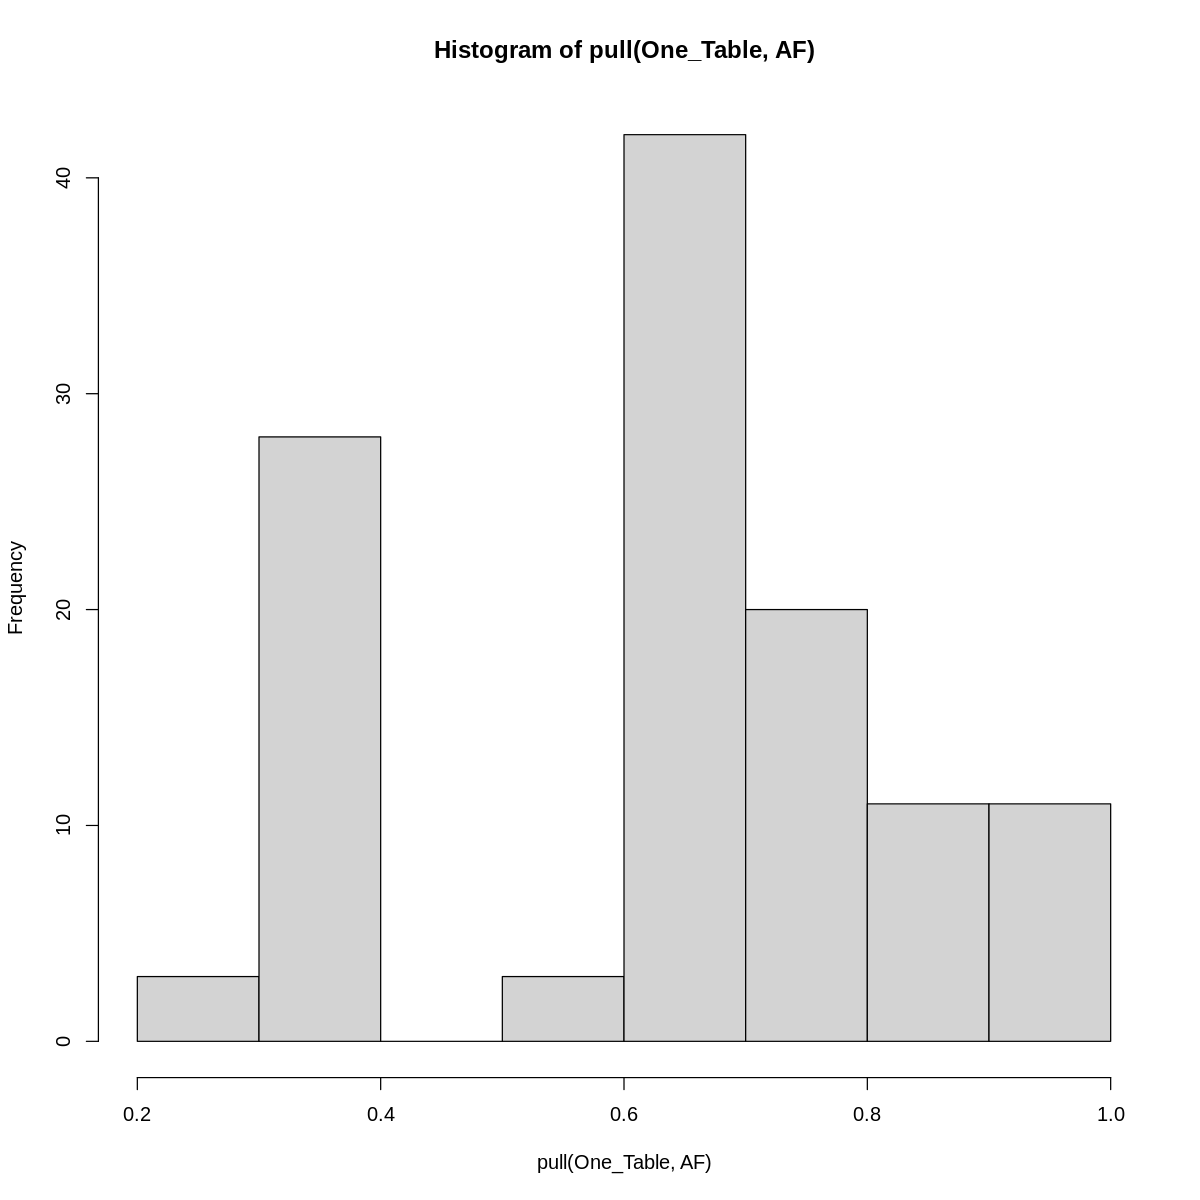

In [421]:
# we need to know which direction the distortion is and how strong it is
# to distinguish different cases

# just add AF to all TRD regions

One_Table<-mutate(One_Table, AF=NA)

for(i in 1:nrow(One_Table)){
    OT_slice<-slice(One_Table, i)
    AF_file<-paste0("/home/jnrunge/data/TRD/results/shiny/",pull(OT_slice, cross),"-AF.csv.gz")
    AF<-fread(AF_file)
    AF<-filter(AF, chr==pull(OT_slice,chr) & global_pos >= pull(OT_slice, global_start) & global_pos <= pull(OT_slice, global_end))
    AF_value<-mean(pull(AF,AD_A1)/pull(AF,sumCount))
    One_Table<-mutate(One_Table, AF=ifelse(ID==pull(OT_slice,ID) & cross == pull(OT_slice, cross),
                                           AF_value, AF))
}

hist(pull(One_Table, AF))

One_Table<-mutate(One_Table, Distorter=ifelse(AF>0.5,"1","2"))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


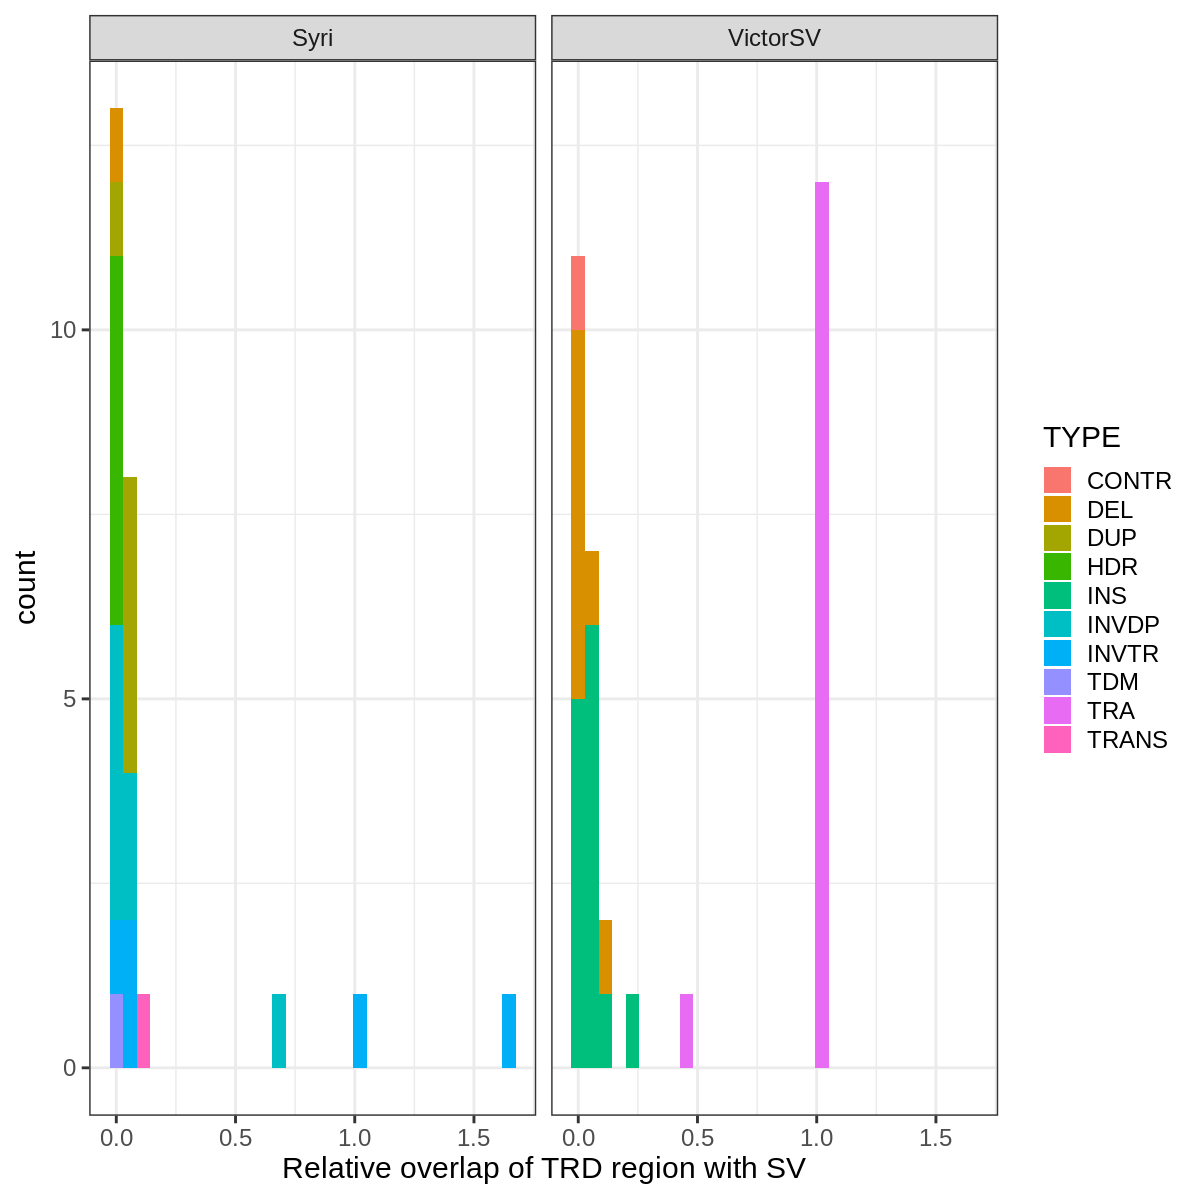

In [422]:
# What sort of SVs are involved?

library(ggplot2)
ggplot(SV_data_summary%>%filter(sum_LEN_rel>=0.01), aes(sum_LEN_rel, fill=TYPE))+
geom_histogram()+
facet_wrap(~source)+#+scale_y_log10()
theme_bw(18)+
xlab("Relative overlap of TRD region with SV")

In [423]:
# add a column that says if this TRD if this cross's strongest TRD

One_Table <- One_Table %>% 
  group_by(cross) %>%
  mutate(strongest = abs(AF - 0.5) == max(abs(AF - 0.5), na.rm = TRUE)) %>%
  ungroup()


Call:
lm(formula = tree_changes_raw ~ log(lengthBp), data = One_Table)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.51014 -0.17564 -0.03690  0.07657  1.64486 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    9.55006    0.48546   19.67   <2e-16 ***
log(lengthBp) -0.58015    0.04031  -14.39   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2921 on 115 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.643,	Adjusted R-squared:  0.6399 
F-statistic: 207.1 on 1 and 115 DF,  p-value: < 2.2e-16


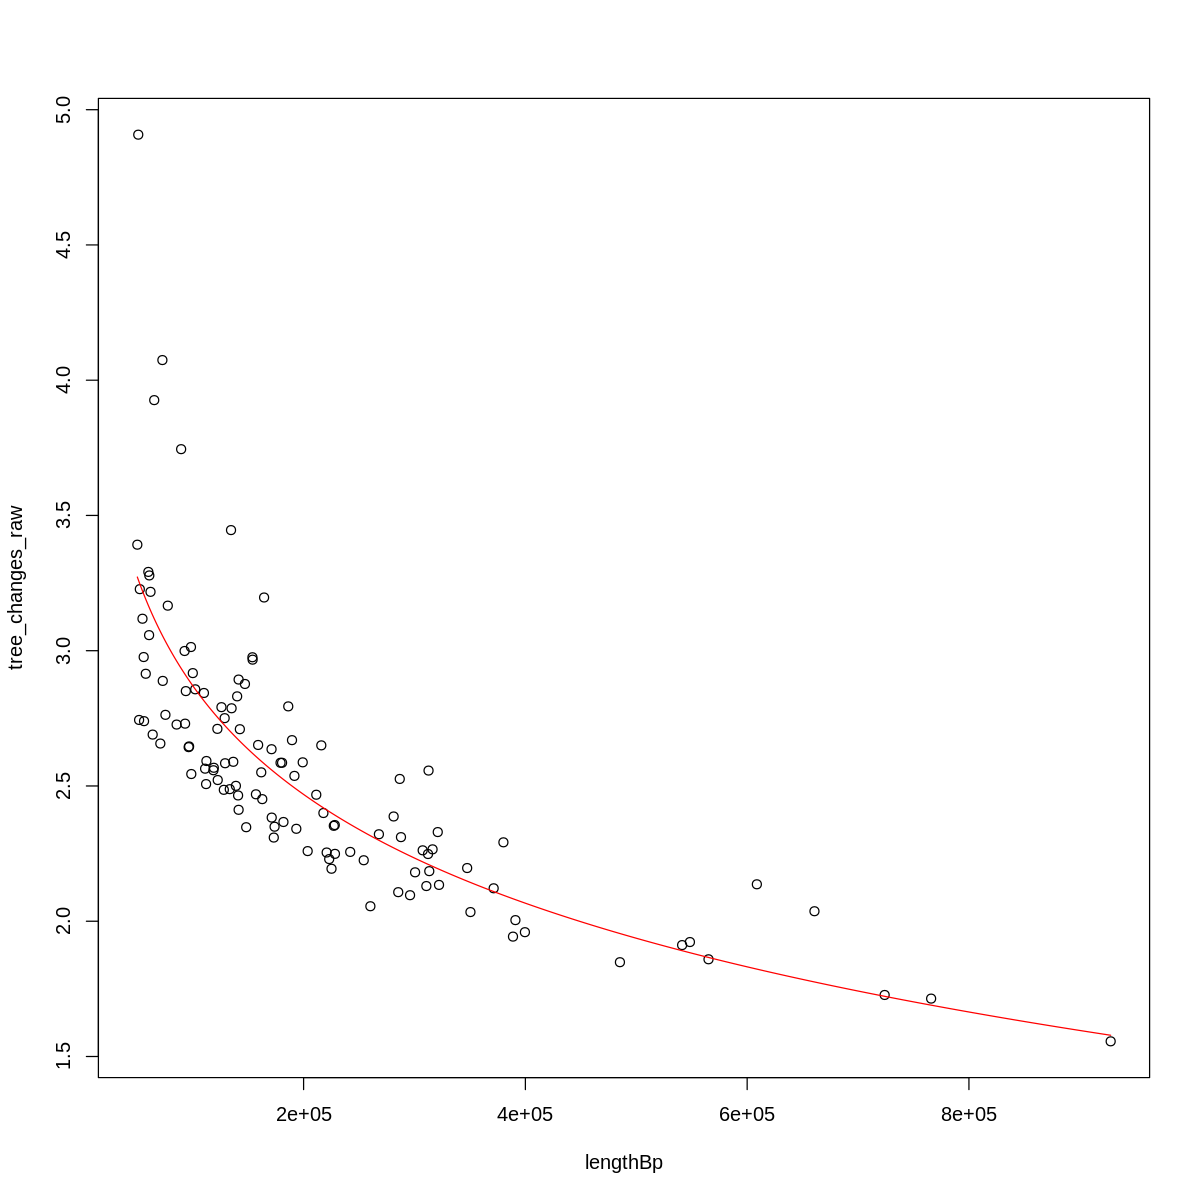

In [424]:
# quick evidence that tree changes at TRD locus needed to be corrected for size of TRD region
# the necessary changes have been made to 02_Local-Phylogeny now.

poly_model <- lm(tree_changes_raw ~ log(lengthBp), data = One_Table)
summary(poly_model)
x <- with(One_Table, seq(min(lengthBp), max(lengthBp), length.out=2000))
y <- predict(poly_model, newdata = data.frame(lengthBp = x))

plot(tree_changes_raw ~ lengthBp, data = One_Table)
lines(x, y, col = "red")

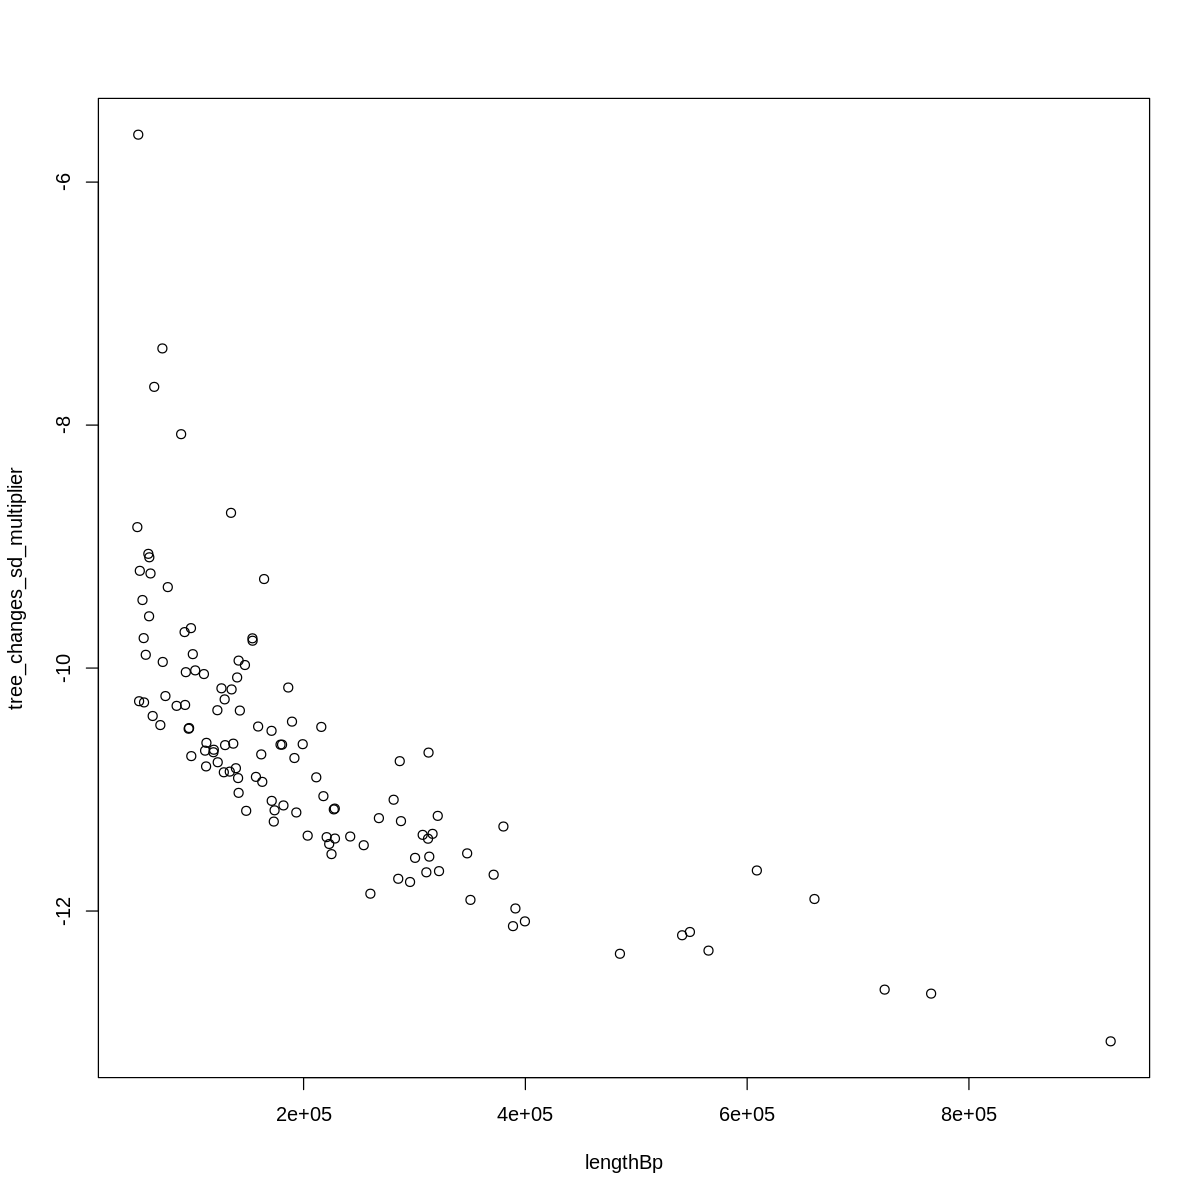

In [425]:
plot(tree_changes_sd_multiplier ~ lengthBp, data = One_Table)


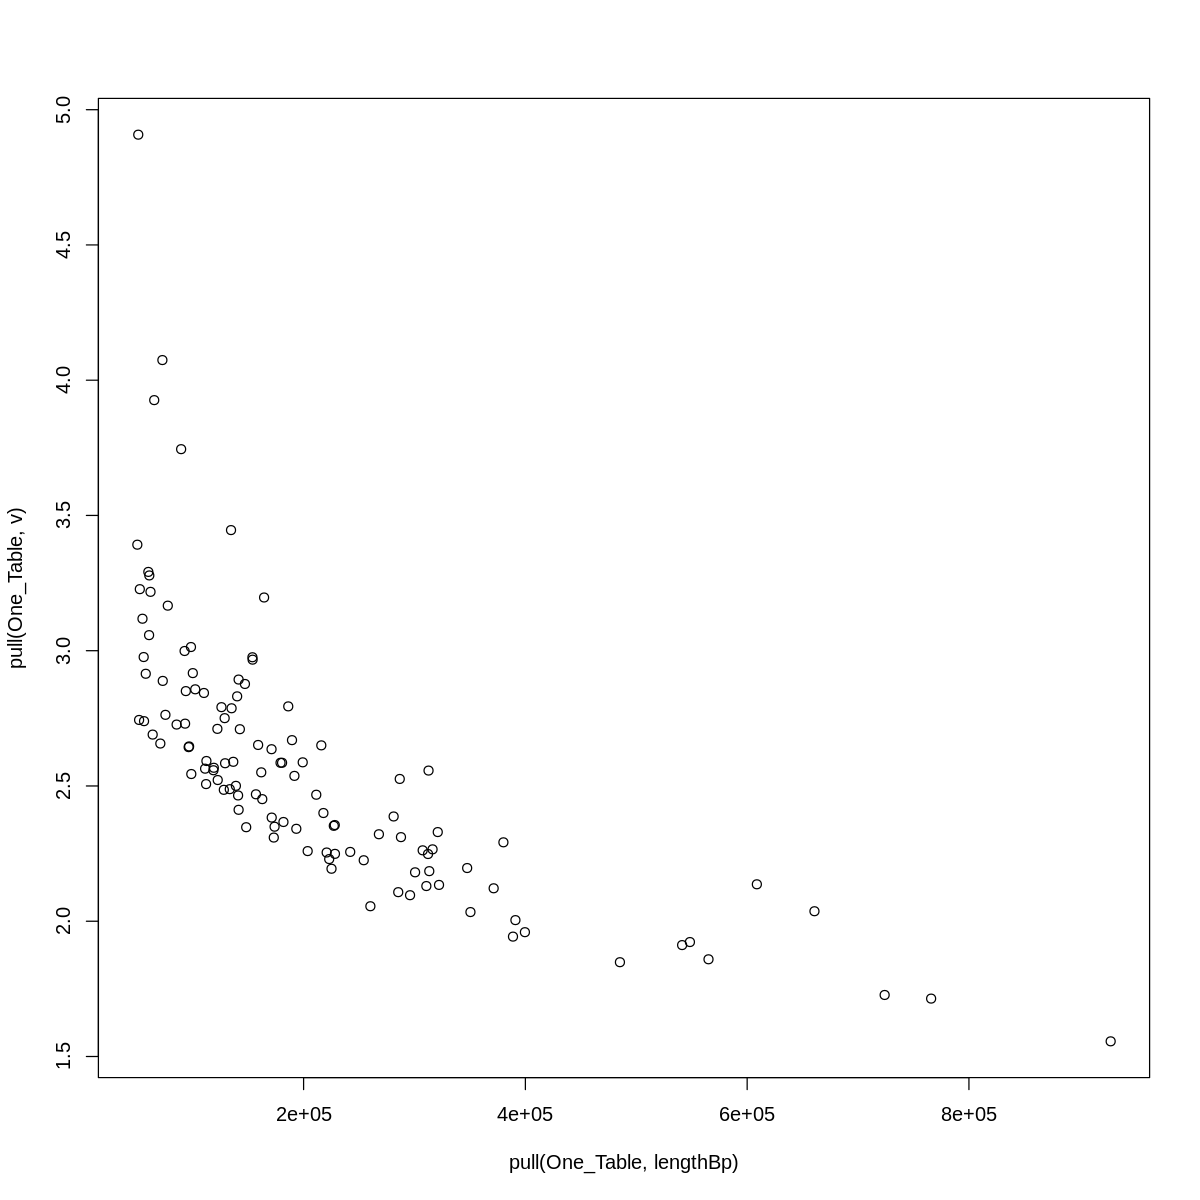

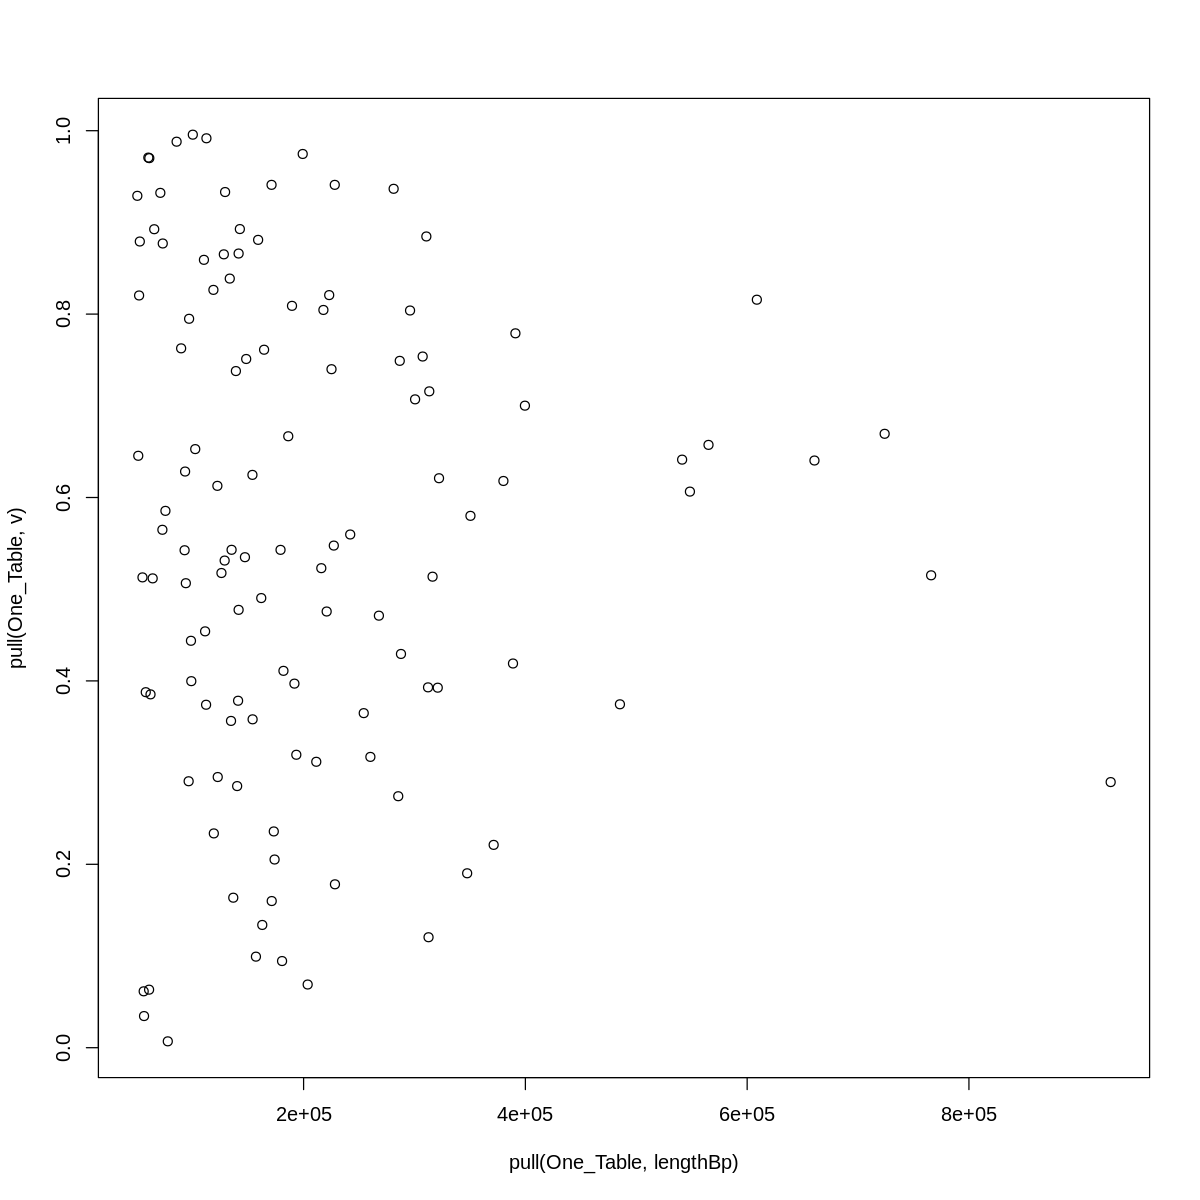

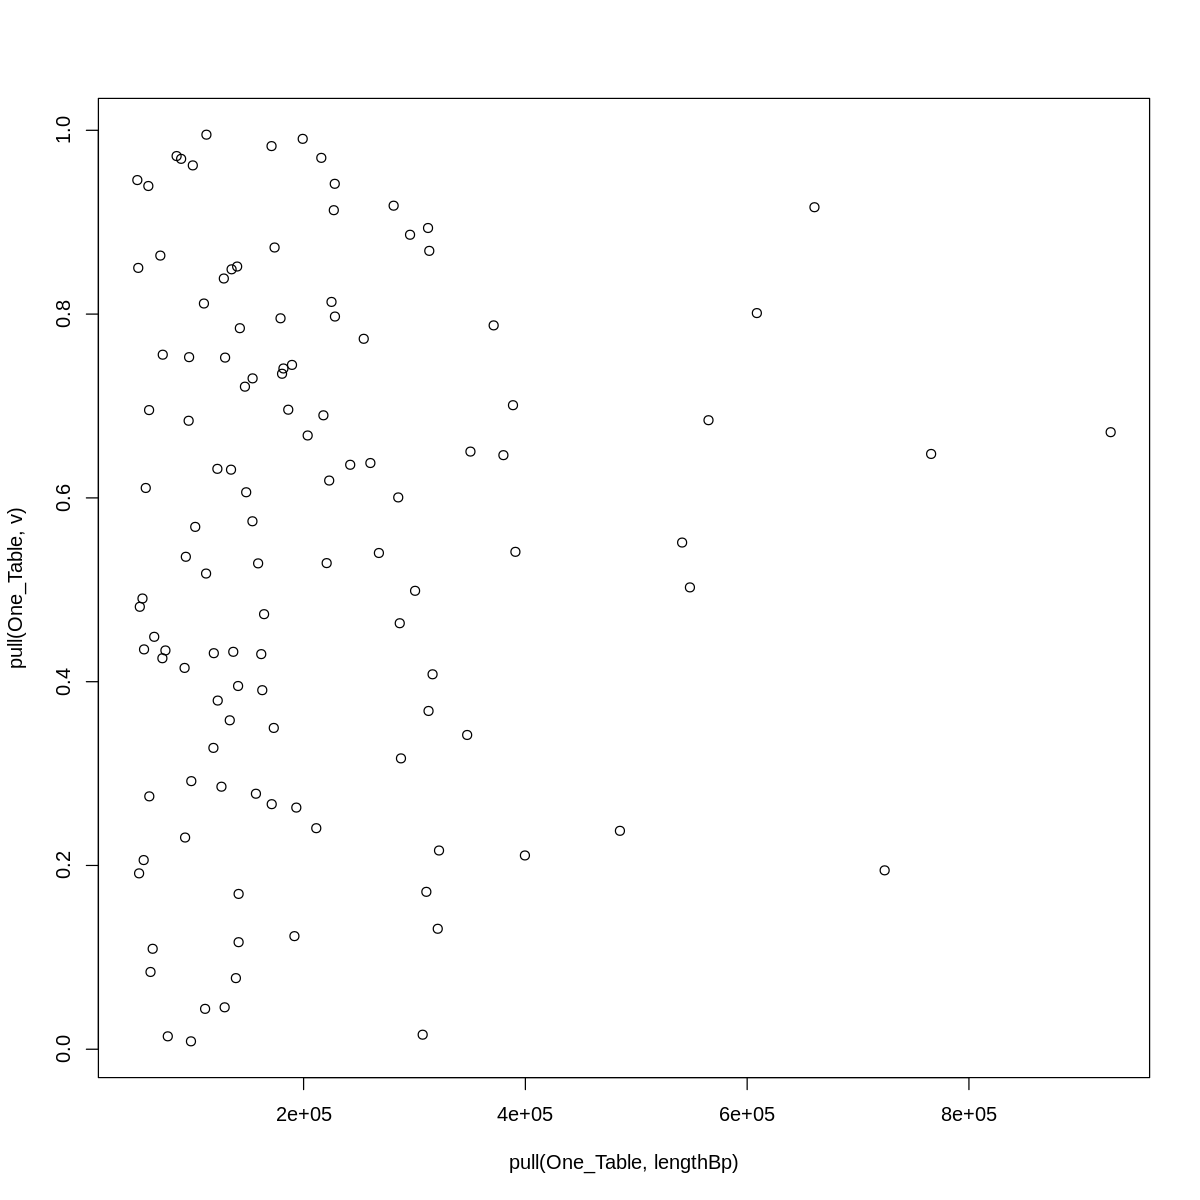

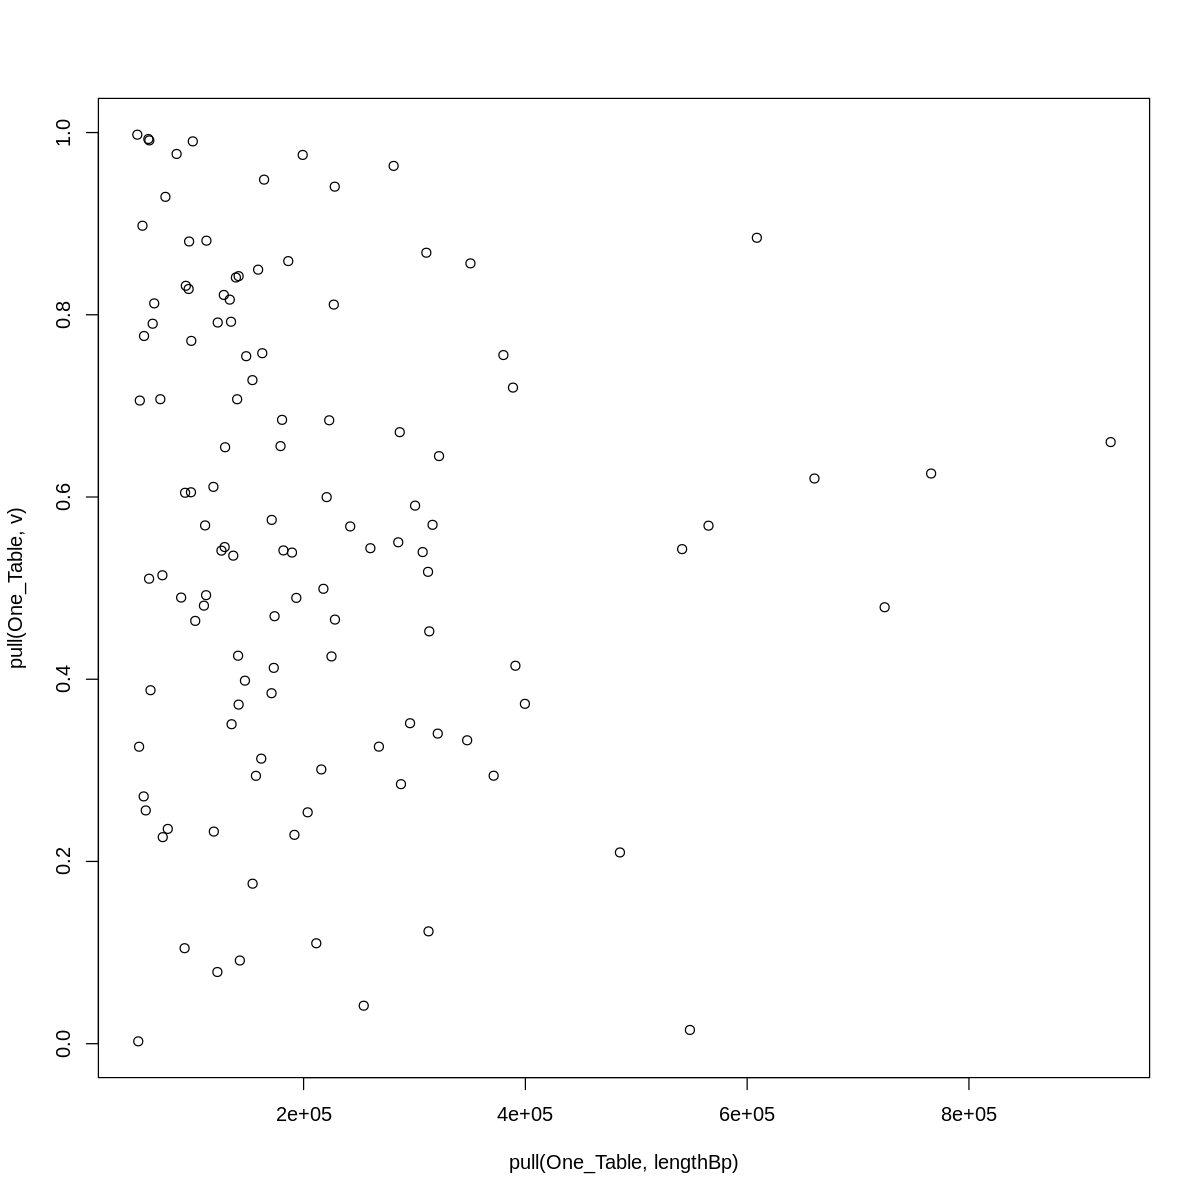

value,pAnova
<chr>,<dbl>
tree_changes_raw,1.574341e-19
PCA_eucldist_quantile_1,6.590876e-01
PCA_eucldist_quantile_2,5.152422e-01
IBS_eucldist_quantile_1,3.134561e-01
IBS_eucldist_quantile_2,2.691188e-01


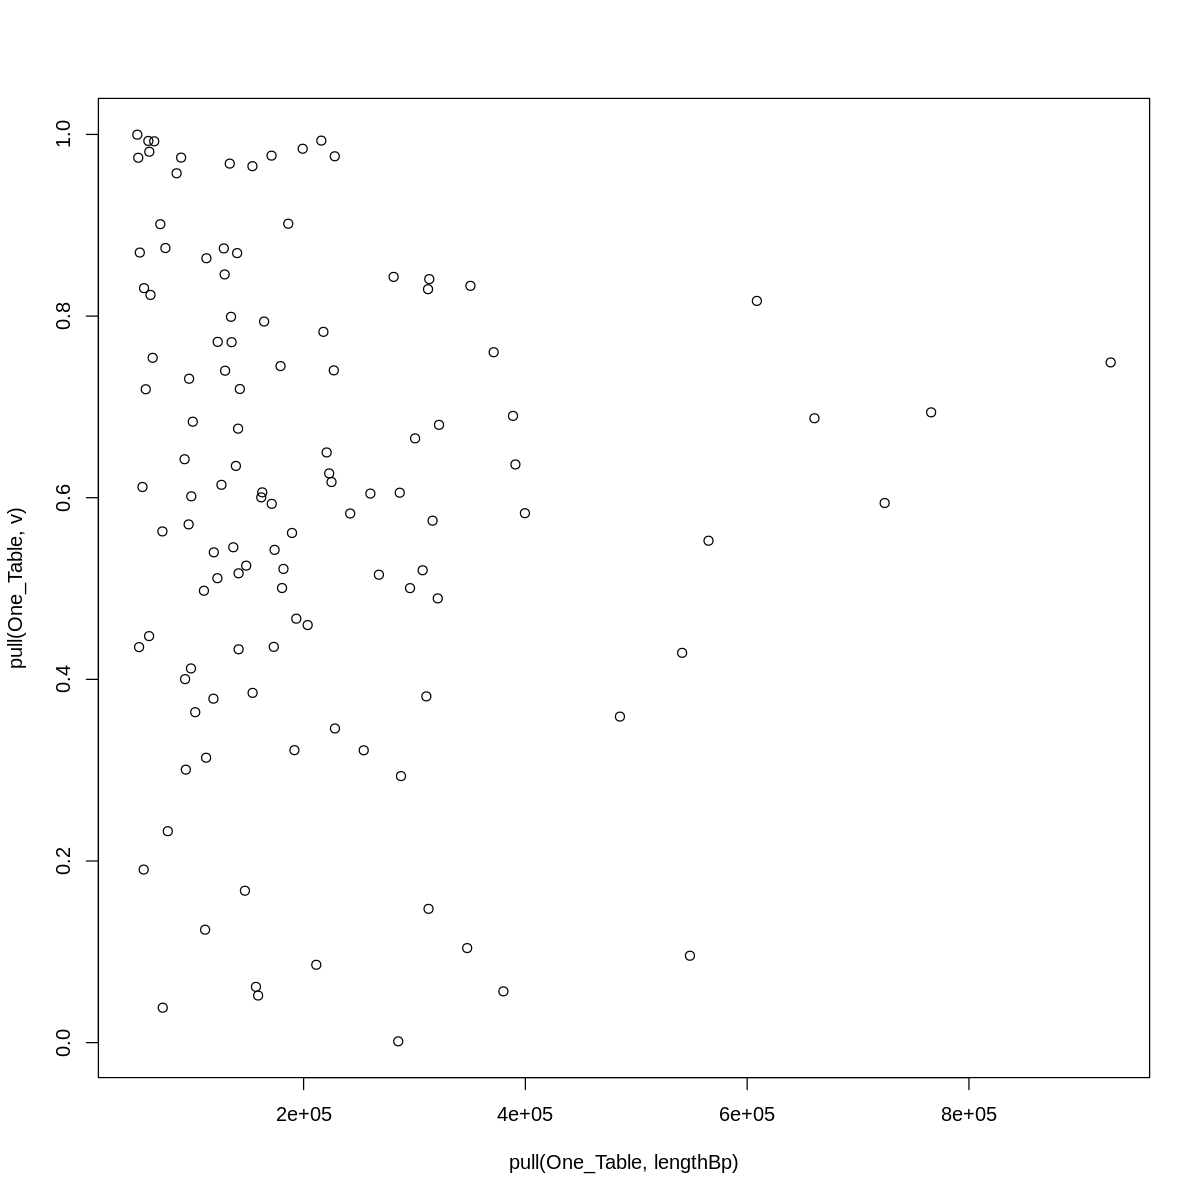

In [426]:
# the same is not the case for other local phylogeny measures
lp_bias<-data.table(value=c("tree_changes_raw","PCA_eucldist_quantile_1",
                           "PCA_eucldist_quantile_2","IBS_eucldist_quantile_1",
                           "IBS_eucldist_quantile_2"), pAnova=NA)
for(v in pull(lp_bias,value)){
    lp_bias<-mutate(lp_bias, pAnova=ifelse(value==v, anova(lm(pull(One_Table,v)~pull(One_Table, lengthBp)), lm(pull(One_Table,v)~1, One_Table))$`Pr(>F)`[2],pAnova))
    plot(pull(One_Table,v)~pull(One_Table, lengthBp))
}

lp_bias

In [427]:
options(repr.plot.width=10, repr.plot.height=10)

# LP data prep

library(stringr)
library(tidyverse)

LP_colnames=c("PCA_eucldist_quantile_1","PCA_eucldist_sd_multiplier_1","IBS_eucldist_quantile_1","IBS_eucldist_sd_multiplier_1","tree_changes_quantile","tree_changes_sd_multiplier","PCA_eucldist_quantile_2","PCA_eucldist_sd_multiplier_2","IBS_eucldist_quantile_2","IBS_eucldist_sd_multiplier_2")
#LP_colnames=LP_colnames[grepl("quant",LP_colnames,fixed=TRUE)]
LP_summary<-pivot_longer(One_Table%>%select(Distorter, strongest, all_of(LP_colnames)), cols = LP_colnames)
LP_summary <- LP_summary %>% mutate(Distorter = case_when(
  substr(name, nchar(name), nchar(name)) %in% c("1", "2") & 
    substr(name, nchar(name), nchar(name)) == Distorter ~ TRUE,
  substr(name, nchar(name), nchar(name)) %in% c("1", "2") ~ FALSE,
  TRUE ~ NA_real_
))
LP_summary <- LP_summary %>% mutate(name = str_remove(name, "_[12]$"))

LP_summary <- LP_summary %>% 
  group_by(name) %>% 
  mutate(value_normalized = ifelse(grepl("quant",name,fixed=TRUE),value-0.5,value)) %>% 
  ungroup()

Next I am showing that the IBS and PCA values are overall higher than from the expected value (0.5 / 0.0), but not by much and the SD data indicates this to be perhaps driven by a few extreme examples, promising potential for interpretation.

Whether the value is taken from distorter or disorted does not matter, however, indicating more general changes at the locus.

**tree data not yet interpreted due to unfinished fix**


	One Sample t-test

data:  filter(LP_summary, name == "IBS_eucldist_quantile") %>% pull(value)
t = 4.791, df = 233, p-value = 2.955e-06
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5470103 0.6126801
sample estimates:
mean of x 
0.5798452 



	One Sample t-test

data:  filter(LP_summary, name == "PCA_eucldist_quantile") %>% pull(value)
t = 3.1324, df = 233, p-value = 0.001956
alternative hypothesis: true mean is not equal to 0.5
95 percent confidence interval:
 0.5204194 0.5896529
sample estimates:
mean of x 
0.5550362 



	One Sample t-test

data:  filter(LP_summary, name == "IBS_eucldist_sd_multiplier") %>% pull(value)
t = 3.3176, df = 233, p-value = 0.001053
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.09803577 0.38473443
sample estimates:
mean of x 
0.2413851 



	One Sample t-test

data:  filter(LP_summary, name == "PCA_eucldist_sd_multiplier") %>% pull(value)
t = 1.5329, df = 233, p-value = 0.1266
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.02956938  0.23689217
sample estimates:
mean of x 
0.1036614 



	Welch Two Sample t-test

data:  filter(LP_summary, Distorter == TRUE, name == "IBS_eucldist_quantile") %>% pull(value) and filter(LP_summary, Distorter == FALSE, name == "IBS_eucldist_quantile") %>% pull(value)
t = 0.31547, df = 227.41, p-value = 0.7527
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.05526985  0.07634112
sample estimates:
mean of x mean of y 
0.5851130 0.5745774 



	Welch Two Sample t-test

data:  filter(LP_summary, Distorter == TRUE, name == "PCA_eucldist_quantile") %>% pull(value) and filter(LP_summary, Distorter == FALSE, name == "PCA_eucldist_quantile") %>% pull(value)
t = -0.29431, df = 231.36, p-value = 0.7688
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.07973449  0.05900983
sample estimates:
mean of x mean of y 
0.5498550 0.5602173 



	Welch Two Sample t-test

data:  filter(LP_summary, Distorter == TRUE, name == "IBS_eucldist_sd_multiplier") %>% pull(value) and filter(LP_summary, Distorter == FALSE, name == "IBS_eucldist_sd_multiplier") %>% pull(value)
t = 0.35252, df = 231.17, p-value = 0.7248
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.2358558  0.3386459
sample estimates:
mean of x mean of y 
0.2670826 0.2156876 



	Welch Two Sample t-test

data:  filter(LP_summary, Distorter == TRUE, name == "PCA_eucldist_sd_multiplier") %>% pull(value) and filter(LP_summary, Distorter == FALSE, name == "PCA_eucldist_sd_multiplier") %>% pull(value)
t = -0.085167, df = 230.15, p-value = 0.9322
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.2785914  0.2555052
sample estimates:
 mean of x  mean of y 
0.09788984 0.10943295 


name,mean
<chr>,<dbl>
IBS_eucldist_quantile,0.5798452
IBS_eucldist_sd_multiplier,0.2413851
PCA_eucldist_quantile,0.5550362
PCA_eucldist_sd_multiplier,0.1036614
tree_changes_quantile,0.0000000
tree_changes_sd_multiplier,-10.6718858


Distorter,strongest,name,value,value_normalized
<dbl>,<lgl>,<chr>,<dbl>,<dbl>
0,FALSE,PCA_eucldist_quantile,0.2951732,-0.2048268
0,FALSE,PCA_eucldist_sd_multiplier,-0.2505780,-0.2505780
0,FALSE,IBS_eucldist_quantile,0.7914947,0.2914947
0,FALSE,IBS_eucldist_sd_multiplier,0.1568852,0.1568852
NA,FALSE,tree_changes_quantile,0.0000000,-0.5000000
NA,FALSE,tree_changes_sd_multiplier,-10.7751836,-10.7751836


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 10 rows containing non-finite values (`stat_bin()`)."


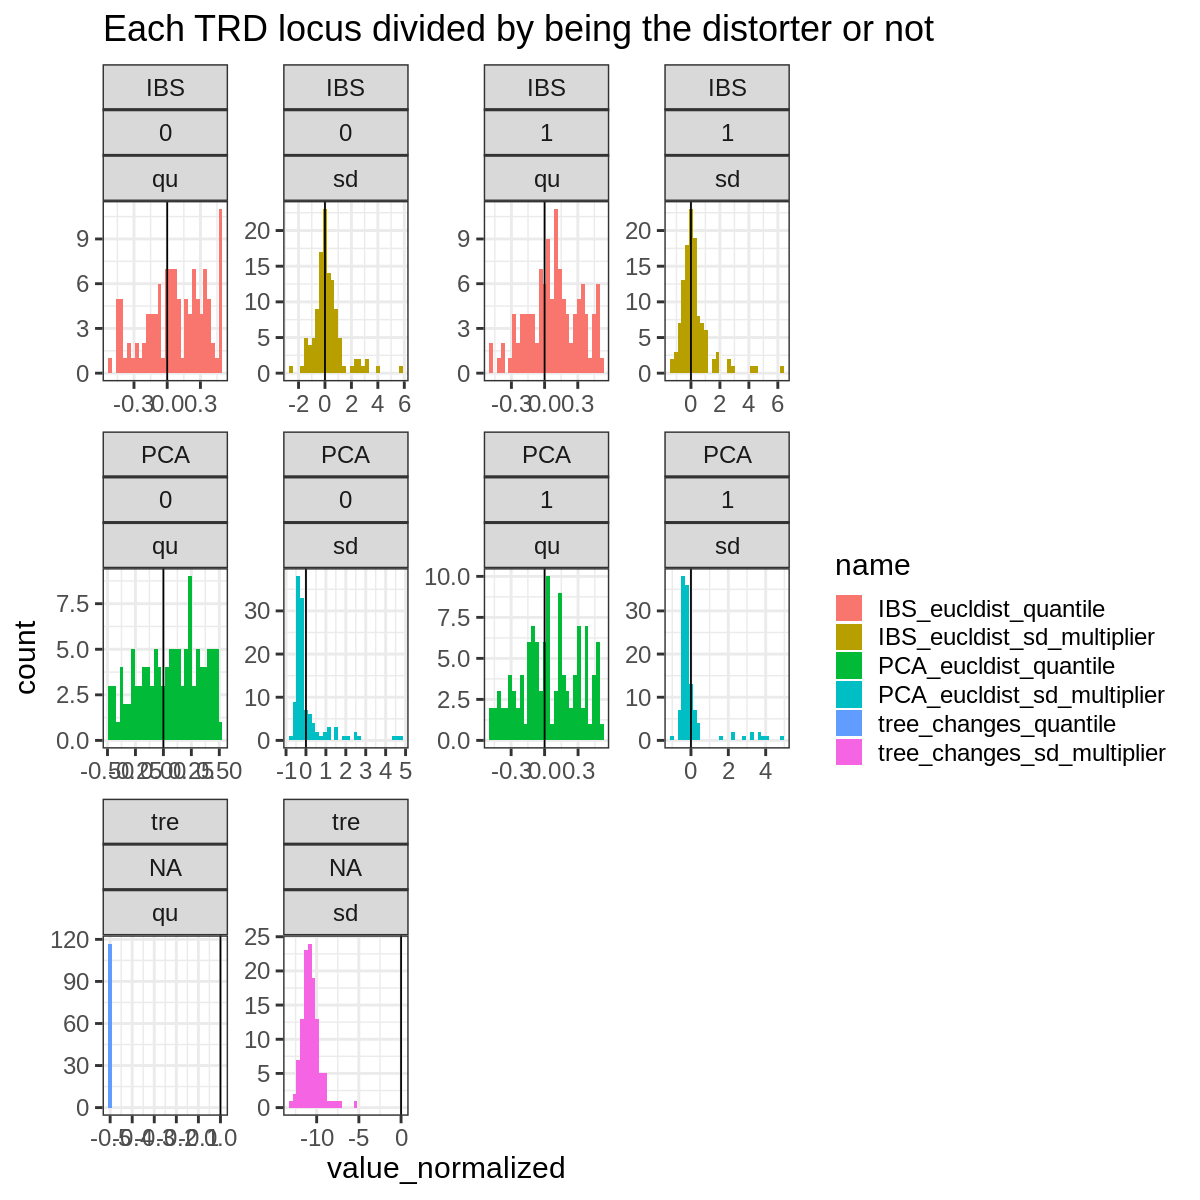

In [428]:
t.test(filter(LP_summary, name == "IBS_eucldist_quantile")%>%pull(value), mu=0.5)
t.test(filter(LP_summary, name == "PCA_eucldist_quantile")%>%pull(value), mu=0.5)
t.test(filter(LP_summary, name == "IBS_eucldist_sd_multiplier")%>%pull(value), mu=0)
t.test(filter(LP_summary, name == "PCA_eucldist_sd_multiplier")%>%pull(value), mu=0)

t.test(filter(LP_summary, Distorter==TRUE, name == "IBS_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==FALSE, name == "IBS_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)
t.test(filter(LP_summary, Distorter==TRUE, name == "PCA_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==FALSE, name == "PCA_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)
t.test(filter(LP_summary, Distorter==TRUE, name == "IBS_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==FALSE, name == "IBS_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)
t.test(filter(LP_summary, Distorter==TRUE, name == "PCA_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==FALSE, name == "PCA_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)

LP_summary%>%group_by(name)%>%summarize(mean=mean(value,na.rm=TRUE))

head(LP_summary)
ggplot(LP_summary, aes(value_normalized,fill=name))+
geom_histogram(position="dodge")+geom_vline(xintercept=0)+
facet_wrap(~substr(name,1,3)+Distorter+substr(name,14,15),scales="free")+theme_bw(18)+ggtitle("Each TRD locus divided by being the distorter or not")

In [429]:
# does not matter if we are looking at the strongest distorter

t.test(filter(LP_summary, Distorter==TRUE&strongest==TRUE, name == "IBS_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==TRUE&strongest==FALSE, name == "IBS_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==TRUE&strongest==TRUE, name == "PCA_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==TRUE&strongest==FALSE, name == "PCA_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==TRUE&strongest==TRUE, name == "IBS_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==TRUE&strongest==FALSE, name == "IBS_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==TRUE&strongest==TRUE, name == "PCA_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==TRUE&strongest==FALSE, name == "PCA_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==FALSE&strongest==TRUE, name == "IBS_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==FALSE&strongest==FALSE, name == "IBS_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==FALSE&strongest==TRUE, name == "PCA_eucldist_quantile")%>%pull(value),
     filter(LP_summary, Distorter==FALSE&strongest==FALSE, name == "PCA_eucldist_quantile")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==FALSE&strongest==TRUE, name == "IBS_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==FALSE&strongest==FALSE, name == "IBS_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

t.test(filter(LP_summary, Distorter==FALSE&strongest==TRUE, name == "PCA_eucldist_sd_multiplier")%>%pull(value),
     filter(LP_summary, Distorter==FALSE&strongest==FALSE, name == "PCA_eucldist_sd_multiplier")%>%pull(value), value = "two.sided", var.equal = FALSE)$p.value

[1] 0.8482837

[1] 0.3062808

[1] 0.8507495

[1] 0.5691293

[1] 0.6304183

[1] 0.1100584

[1] 0.8369559

[1] 0.1743551

In [430]:
# pixy data overview

pixy_files<-list.files("/home/jnrunge/data/trd/pop_genomics","relative-measures.RDS$",full.names = TRUE)
pixy_df<-data.table()
for(f in pixy_files){
    f_<-readRDS(f)


f_ <- lapply(f_, function(x) {
  if ("pi_pop" %in% names(x)) {
    names(x)[names(x) == "pi_pop"] <- "sum_value"
  }
  x
})

df <- f_ %>%
  purrr::imap_dfr(function(y, name) {
    data.table(analysis = name, t(y))
  })
    
    df<-mutate(df, file=basename(f))
    
    pixy_df<-bind_rows(pixy_df, df)
    
}
pixy_df<-mutate(pixy_df, ecdf_value=as.numeric(ecdf_value))
pixy_df<-mutate(pixy_df, standardized_measure=as.numeric(standardized_measure))
pixy_df<-mutate(pixy_df, sum_value=as.numeric(sum_value))
pixy_df_OG<-pixy_df
head(pixy_df)






analysis,sum_value,ecdf_value,standardized_measure,file
<chr>,<dbl>,<dbl>,<dbl>,<chr>
pi_distorter,0.0010105359,0.3667482,-0.08784650,ChrisC1.1-relative-measures.RDS
pi_other,0.0066415474,0.9249171,0.13720789,ChrisC1.1-relative-measures.RDS
fst,0.0942122786,0.7417693,0.32274522,ChrisC1.1-relative-measures.RDS
dxy,0.0049723317,0.8780999,0.06872751,ChrisC1.1-relative-measures.RDS
pi_distorter,0.0008429781,0.6485542,-0.03174992,ChrisC1.13-relative-measures.RDS
pi_other,0.0036112803,0.5879682,-0.05219997,ChrisC1.13-relative-measures.RDS


In [431]:
getCrossAndID=function(x){
    x<-strsplit(x, "-", fixed=TRUE)[[1]][1]
    x<-strsplit(x, ".", fixed=TRUE)[[1]]
    return(data.table(cross=x[1], ID=x[2]))
}

pixy_df<-bind_cols(pixy_df, bind_rows(lapply(pull(pixy_df, file), getCrossAndID)))
head(pixy_df)
pixy_df%>%pull(cross)%>%unique()

pixy_df<-select(pixy_df, -file)%>%
  pivot_wider(names_from = analysis, 
              values_from = c(sum_value, ecdf_value, standardized_measure),
              names_sep = "_",
              id_cols = c(cross, ID))


analysis,sum_value,ecdf_value,standardized_measure,file,cross,ID
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
pi_distorter,0.0010105359,0.3667482,-0.08784650,ChrisC1.1-relative-measures.RDS,ChrisC1,1
pi_other,0.0066415474,0.9249171,0.13720789,ChrisC1.1-relative-measures.RDS,ChrisC1,1
fst,0.0942122786,0.7417693,0.32274522,ChrisC1.1-relative-measures.RDS,ChrisC1,1
dxy,0.0049723317,0.8780999,0.06872751,ChrisC1.1-relative-measures.RDS,ChrisC1,1
pi_distorter,0.0008429781,0.6485542,-0.03174992,ChrisC1.13-relative-measures.RDS,ChrisC1,13
pi_other,0.0036112803,0.5879682,-0.05219997,ChrisC1.13-relative-measures.RDS,ChrisC1,13


[1] "ChrisC1" "ChrisC3" "ChrisC4" "ChrisC5" "ChrisC7" "ChrisC8" "YJNRC12"
 [8] "YJNRC14" "YJNRC15" "YJNRC18" "YJNRC19" "YJNRC2"  "YJNRC20" "YJNRC21"
[15] "YJNRC22" "YJNRC23" "YJNRC24" "YJNRC25" "YJNRC26" "YJNRC27" "YJNRC29"
[22] "YJNRC3"  "YJNRC30" "YJNRC31" "YJNRC32" "YJNRC4"  "YJNRC5"  "YJNRC6" 
[29] "YJNRC7"  "YJNRC8"  "YJNRC9"

In [432]:
pixy_df<-mutate(pixy_df, ID=as.numeric(ID))
One_Table<-full_join(One_Table, pixy_df, by=c("cross","ID"))

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 816 rows containing non-finite values (`stat_smooth()`)."
Warning message:
"Removed 816 rows containing missing values (`geom_point()`)."


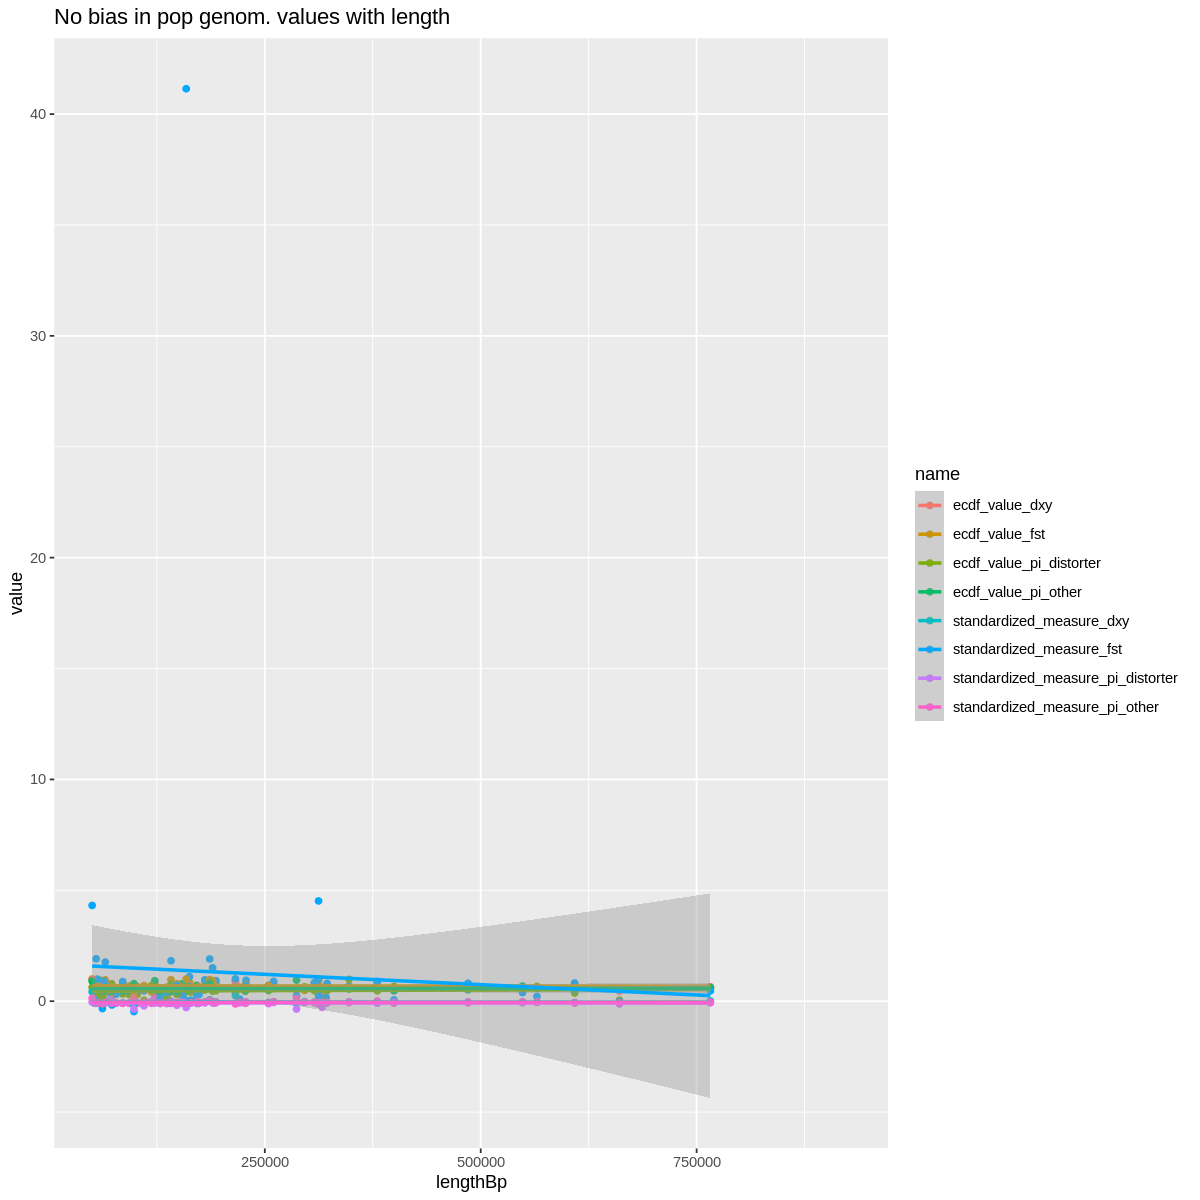

In [433]:
ggplot(One_Table%>%select(cross,ID,ecdf_value_fst,ecdf_value_dxy,ecdf_value_pi_distorter,ecdf_value_pi_other,standardized_measure_fst,standardized_measure_dxy,standardized_measure_pi_distorter,standardized_measure_pi_other,lengthBp)%>%
pivot_longer(cols = c(ecdf_value_fst, ecdf_value_dxy, ecdf_value_pi_distorter, 
                        ecdf_value_pi_other, standardized_measure_fst, standardized_measure_dxy, 
                        standardized_measure_pi_distorter, standardized_measure_pi_other)),
       aes(lengthBp, value, color=name))+
geom_point()+geom_smooth(method="lm")+ggtitle("No bias in pop genom. values with length")

evidence that fst is increased at trd loci, but mixed results for other values; probably more interesting to look at specific examples

In [434]:
pixy_global_tests<-data.table(value=c("ecdf_value_fst","ecdf_value_dxy","ecdf_value_pi_distorter","ecdf_value_pi_other","standardized_measure_fst","standardized_measure_dxy","standardized_measure_pi_distorter","standardized_measure_pi_other"),
                             p=NA, mean=NA)
for(i in 1:nrow(pixy_global_tests)){
    pgt_slice<-slice(pixy_global_tests, i)
    pgt_slice_value<-pull(pgt_slice, value)
    ttest_value<-t.test(pull(One_Table, pgt_slice_value), mu=ifelse(startsWith(pgt_slice_value,"ecdf"),0.5,0))$p.value
    pixy_global_tests<-mutate(pixy_global_tests, p=ifelse(value==pgt_slice_value,ttest_value,p))
    pixy_global_tests<-mutate(pixy_global_tests, mean=ifelse(value==pgt_slice_value,mean(pull(One_Table, pgt_slice_value),na.rm=TRUE),mean))
}
pixy_global_tests

value,p,mean
<chr>,<dbl>,<dbl>
ecdf_value_fst,6.508229e-19,0.664892722
ecdf_value_dxy,4.588510e-12,0.611060071
ecdf_value_pi_distorter,6.404310e-01,0.489744355
ecdf_value_pi_other,6.940566e-08,0.581251544
standardized_measure_fst,1.429441e-02,0.887087392
standardized_measure_dxy,6.202278e-01,-0.008630039
standardized_measure_pi_distorter,3.062531e-16,-0.075228859
standardized_measure_pi_other,9.112295e-14,-0.050667244


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 54 rows containing non-finite values (`stat_bin()`)."


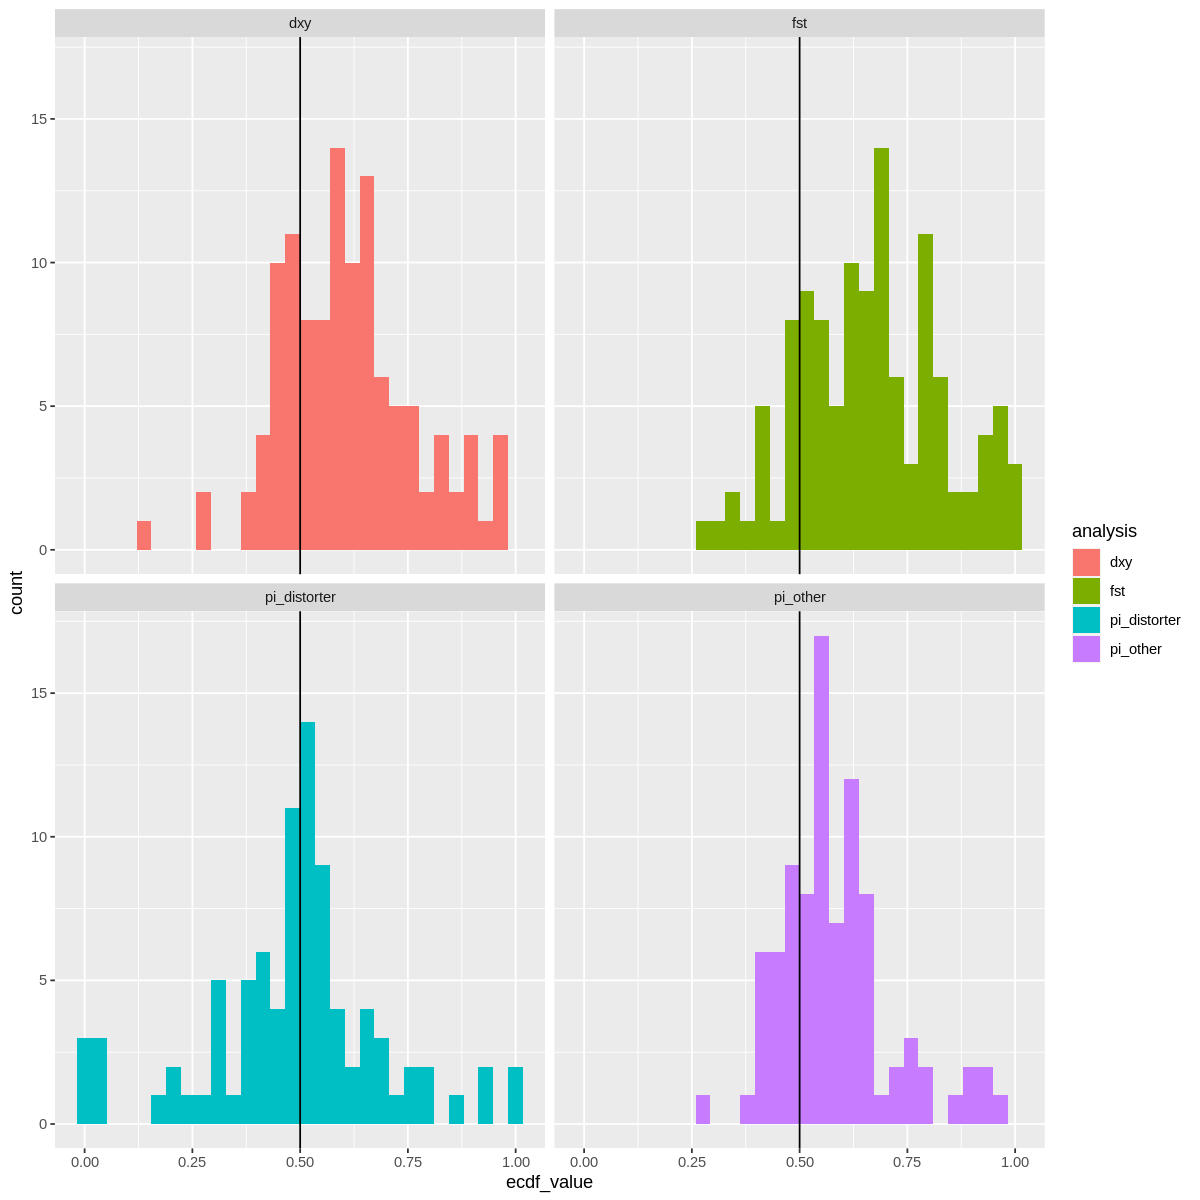

In [435]:
ggplot(pixy_df_OG, aes(ecdf_value, fill=analysis))+
geom_histogram()+facet_wrap(~analysis)+geom_vline(xintercept = 0.5)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 54 rows containing non-finite values (`stat_bin()`)."


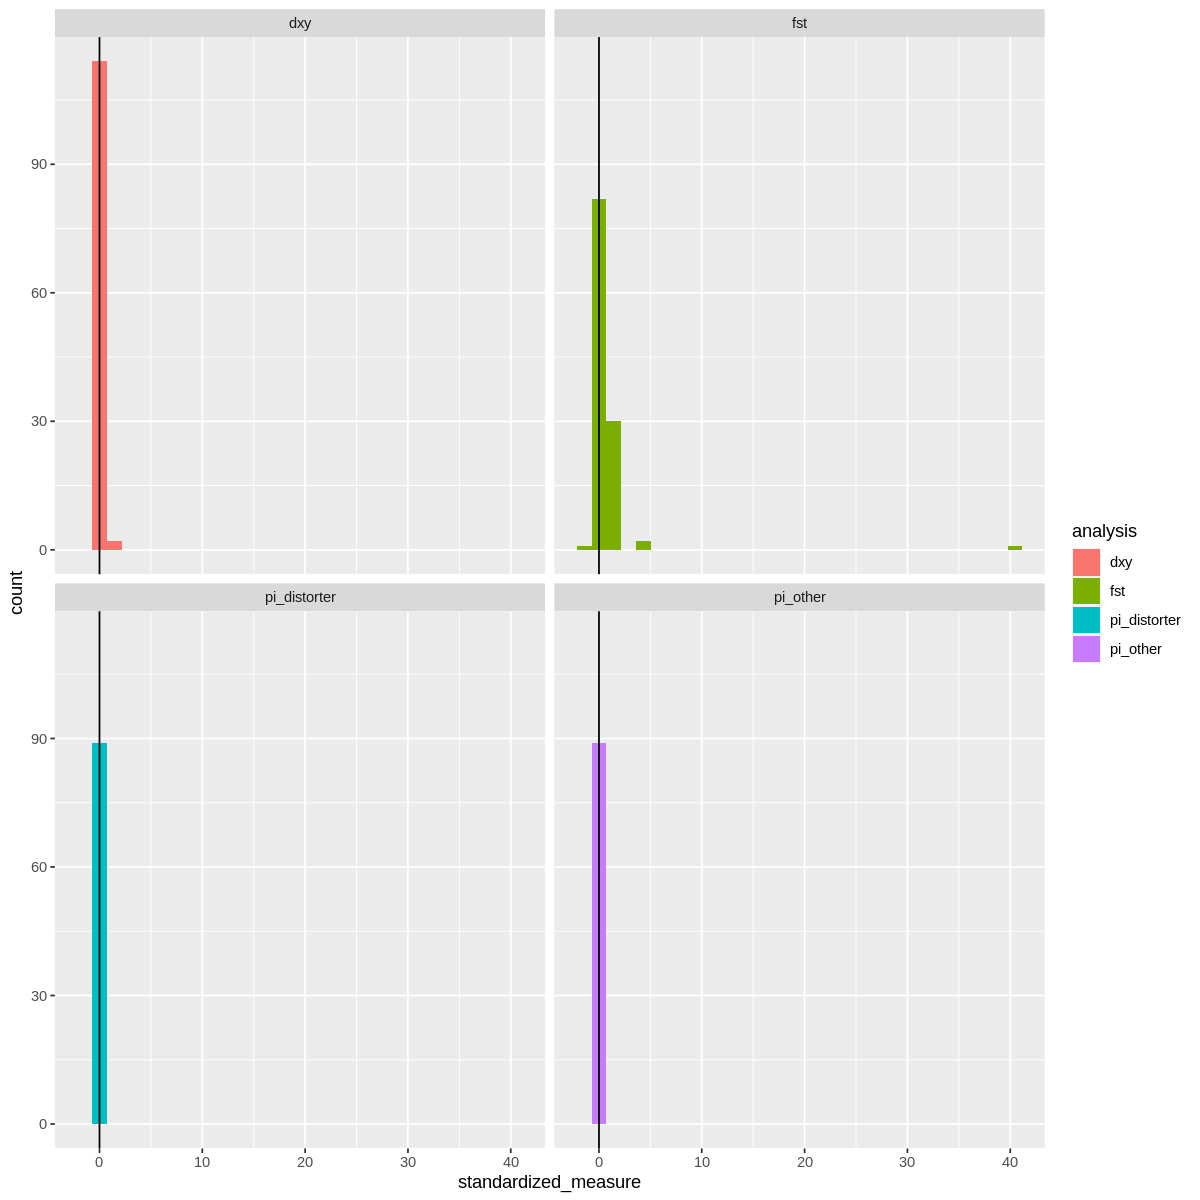

In [436]:
ggplot(pixy_df_OG, aes(standardized_measure, fill=analysis))+
geom_histogram()+facet_wrap(~analysis)+geom_vline(xintercept = 0)

In [437]:
colnames(One_Table)

[1] "ID"                                "lengthSNPs"                       
 [3] "chr"                               "global_start"                     
 [5] "global_end"                        "lengthBp"                         
 [7] "cross"                             "start"                            
 [9] "end"                               "PCA_eucldist_quantile_1"          
[11] "PCA_eucldist_sd_multiplier_1"      "IBS_eucldist_quantile_1"          
[13] "IBS_eucldist_sd_multiplier_1"      "tree_changes_quantile"            
[15] "tree_changes_sd_multiplier"        "tree_changes_raw"                 
[17] "PCA_eucldist_quantile_2"           "PCA_eucldist_sd_multiplier_2"     
[19] "IBS_eucldist_quantile_2"           "IBS_eucldist_sd_multiplier_2"     
[21] "AF"                                "Distorter"                        
[23] "strongest"                         "sum_value_pi_distorter"           
[25] "sum_value_pi_other"                "sum_value_fst"                    
[27] "sum_value_dxy"                     "ecdf_value_pi_distorter"          
[29] "ecdf_value_pi_other"               "ecdf_value_fst"                   
[31] "ecdf_value_dxy"                    "standardized_measure_pi_distorter"
[33] "standardized_measure_pi_other"     "standardized_measure_fst"         
[35] "standardized_measure_dxy"

In [438]:
# add SV data to big table
One_Table<-left_join(One_Table,pivot_wider(SV_data_summary, id_cols=c("cross","ID"), names_from=c("TYPE","source"), values_from = c("sum_LEN_rel"), values_fill = 0), by=c("cross","ID"))

In [439]:
# add LD and TD data
LD_data<-fread("/home/jnrunge/data/trd/LD_data/LD_plot_data.csv.gz")
TD_data<-fread("/home/jnrunge/data/trd/TD_data/TD_plot_data.csv.gz")

One_Table<-left_join(One_Table, LD_data)
One_Table<-left_join(One_Table, TD_data)

Joining with `by = join_by(ID, cross)`
Joining with `by = join_by(ID, cross)`


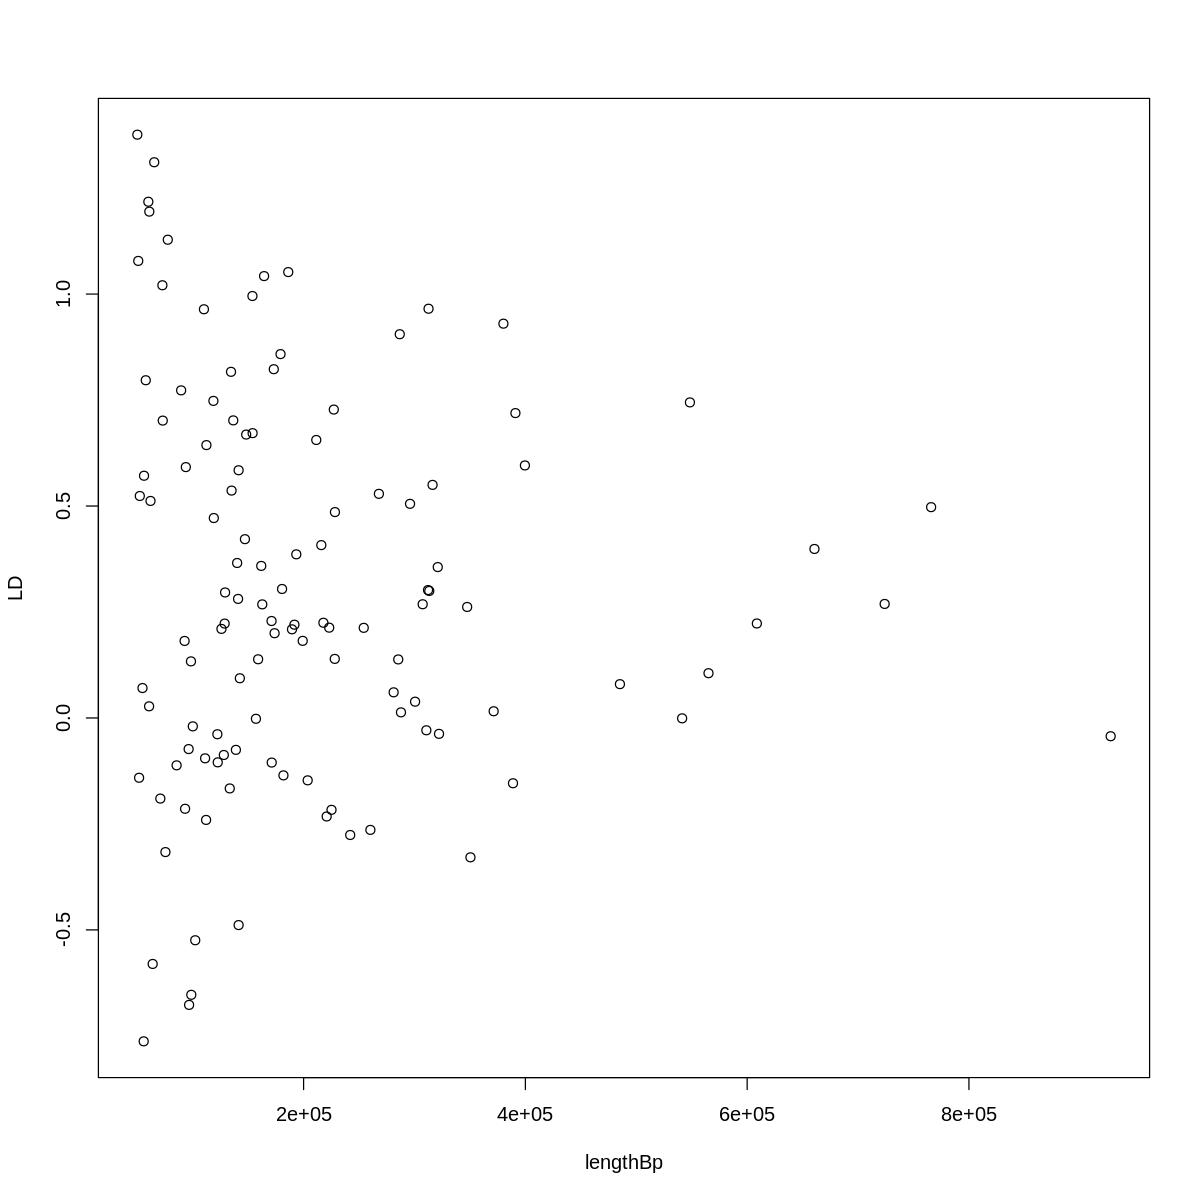

In [473]:
plot(LD ~ lengthBp, One_Table)

In [440]:
paste(colnames(One_Table),collapse=",")

[1] "ID,lengthSNPs,chr,global_start,global_end,lengthBp,cross,start,end,PCA_eucldist_quantile_1,PCA_eucldist_sd_multiplier_1,IBS_eucldist_quantile_1,IBS_eucldist_sd_multiplier_1,tree_changes_quantile,tree_changes_sd_multiplier,tree_changes_raw,PCA_eucldist_quantile_2,PCA_eucldist_sd_multiplier_2,IBS_eucldist_quantile_2,IBS_eucldist_sd_multiplier_2,AF,Distorter,strongest,sum_value_pi_distorter,sum_value_pi_other,sum_value_fst,sum_value_dxy,ecdf_value_pi_distorter,ecdf_value_pi_other,ecdf_value_fst,ecdf_value_dxy,standardized_measure_pi_distorter,standardized_measure_pi_other,standardized_measure_fst,standardized_measure_dxy,CPG_Syri,CPL_Syri,DEL_Syri,DEL_VictorSV,DUP_Syri,DUP_VictorSV,HDR_Syri,INS_Syri,INS_VictorSV,INVDP_Syri,TDM_Syri,TRANS_Syri,INVTR_Syri,TRA_VictorSV,CONTR_VictorSV,LD,LD_sd_multi_1,LD_sd_multi_2,TD,TD_sd_multi,TD_ecdf"

In [441]:
scale_numeric<-function(x){
    return(as.numeric(scale(x, center = FALSE)))
}

In [442]:
colnames(One_Table)

[1] "ID"                                "lengthSNPs"                       
 [3] "chr"                               "global_start"                     
 [5] "global_end"                        "lengthBp"                         
 [7] "cross"                             "start"                            
 [9] "end"                               "PCA_eucldist_quantile_1"          
[11] "PCA_eucldist_sd_multiplier_1"      "IBS_eucldist_quantile_1"          
[13] "IBS_eucldist_sd_multiplier_1"      "tree_changes_quantile"            
[15] "tree_changes_sd_multiplier"        "tree_changes_raw"                 
[17] "PCA_eucldist_quantile_2"           "PCA_eucldist_sd_multiplier_2"     
[19] "IBS_eucldist_quantile_2"           "IBS_eucldist_sd_multiplier_2"     
[21] "AF"                                "Distorter"                        
[23] "strongest"                         "sum_value_pi_distorter"           
[25] "sum_value_pi_other"                "sum_value_fst"                    
[27] "sum_value_dxy"                     "ecdf_value_pi_distorter"          
[29] "ecdf_value_pi_other"               "ecdf_value_fst"                   
[31] "ecdf_value_dxy"                    "standardized_measure_pi_distorter"
[33] "standardized_measure_pi_other"     "standardized_measure_fst"         
[35] "standardized_measure_dxy"          "CPG_Syri"                         
[37] "CPL_Syri"                          "DEL_Syri"                         
[39] "DEL_VictorSV"                      "DUP_Syri"                         
[41] "DUP_VictorSV"                      "HDR_Syri"                         
[43] "INS_Syri"                          "INS_VictorSV"                     
[45] "INVDP_Syri"                        "TDM_Syri"                         
[47] "TRANS_Syri"                        "INVTR_Syri"                       
[49] "TRA_VictorSV"                      "CONTR_VictorSV"                   
[51] "LD"                                "LD_sd_multi_1"                    
[53] "LD_sd_multi_2"                     "TD"                               
[55] "TD_sd_multi"                       "TD_ecdf"

In [443]:
summarize(group_by(One_Table, Distorter), n=n())

Distorter,n
<chr>,<int>
1,87
2,31
NA,50


In [444]:
# acknowldgeding TRD direction in the PCA / IBS data

One_Table<-mutate(One_Table, PCA_eucldist_sd_multiplier_distorter=ifelse(Distorter==1,
                                                                         PCA_eucldist_sd_multiplier_1,
                                                                         PCA_eucldist_sd_multiplier_2),
                    PCA_eucldist_sd_multiplier_other=ifelse(Distorter==2,
                                                                         PCA_eucldist_sd_multiplier_1,
                                                                         PCA_eucldist_sd_multiplier_2),
                 IBS_eucldist_sd_multiplier_distorter=ifelse(Distorter==1,
                                                                         IBS_eucldist_sd_multiplier_1,
                                                                         IBS_eucldist_sd_multiplier_2),
                 IBS_eucldist_sd_multiplier_other=ifelse(Distorter==2,
                                                                         IBS_eucldist_sd_multiplier_1,
                                                                         IBS_eucldist_sd_multiplier_2))

name,mean,ttest_p_value
<chr>,<dbl>,<dbl>
IBS_eucldist_sd_multiplier_distorter,0.267082633,8.621690e-03
IBS_eucldist_sd_multiplier_other,0.215687563,4.442233e-02
LD_sd_multi_1,2.594802426,3.887725e-50
LD_sd_multi_2,-0.920053944,5.749675e-27
PCA_eucldist_sd_multiplier_distorter,0.097889839,3.298542e-01
PCA_eucldist_sd_multiplier_other,0.109432948,2.338557e-01
TD_sd_multi,0.126026376,8.173508e-02
standardized_measure_dxy,-0.008630039,6.202278e-01
standardized_measure_fst,0.887087392,1.429441e-02


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


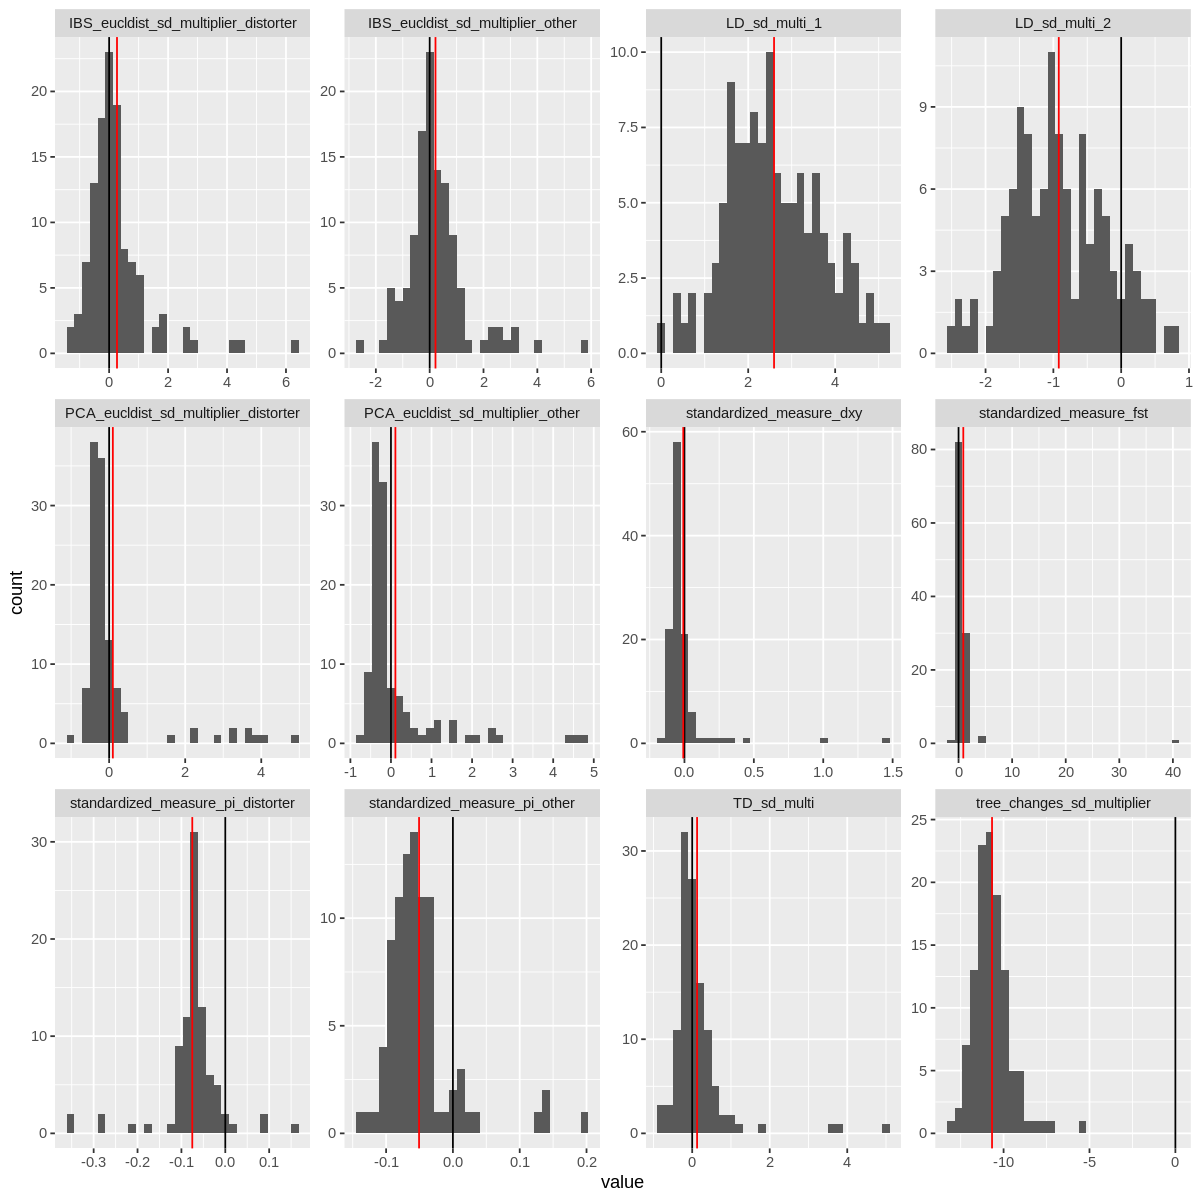

In [475]:
# is the mean different from expectation?

One_Table_sd_based_values<-One_Table%>%select(matches("sd|standardized"))%>%select(!matches("multiplier_[12]"))%>%
pivot_longer(cols=everything())%>%filter(!is.na(value))

One_Table_sd_based_values_means<-One_Table_sd_based_values%>%group_by(name)%>%summarize(mean=mean(value),
                                                                                       ttest_p_value=t.test(value,
                                                                                                           mu=0)$p.value)
One_Table_sd_based_values_means
ggplot(One_Table_sd_based_values,
      aes(value))+
geom_histogram()+facet_wrap(~name, scales="free")+geom_vline(xintercept=0)+
geom_vline(data=One_Table_sd_based_values_means, aes(xintercept=mean), color="red")



In [476]:
knitr::kable(One_Table_sd_based_values_means)



|name                                 |        mean| ttest_p_value|
|:------------------------------------|-----------:|-------------:|
|IBS_eucldist_sd_multiplier_distorter |   0.2670826|     0.0086217|
|IBS_eucldist_sd_multiplier_other     |   0.2156876|     0.0444223|
|LD_sd_multi_1                        |   2.5948024|     0.0000000|
|LD_sd_multi_2                        |  -0.9200539|     0.0000000|
|PCA_eucldist_sd_multiplier_distorter |   0.0978898|     0.3298542|
|PCA_eucldist_sd_multiplier_other     |   0.1094329|     0.2338557|
|TD_sd_multi                          |   0.1260264|     0.0817351|
|standardized_measure_dxy             |  -0.0086300|     0.6202278|
|standardized_measure_fst             |   0.8870874|     0.0142944|
|standardized_measure_pi_distorter    |  -0.0752289|     0.0000000|
|standardized_measure_pi_other        |  -0.0506672|     0.0000000|
|tree_changes_sd_multiplier           | -10.6718858|     0.0000000|

In [445]:
# getting rid of the SVs and also NAs
# only one type of variable (sd multipliers) for now so that no scaling issues can arise
clustering_subset<-select(One_Table, AF,
                         PCA_eucldist_sd_multiplier_distorter,IBS_eucldist_sd_multiplier_distorter,
                          #tree_changes_quantile,tree_changes_sd_multiplier,tree_changes_raw,
                        PCA_eucldist_sd_multiplier_other,IBS_eucldist_sd_multiplier_other,standardized_measure_pi_distorter,standardized_measure_pi_other,standardized_measure_fst,standardized_measure_dxy,LD_sd_multi_2,TD_sd_multi)


clustering_subset <- clustering_subset %>% mutate(AF=abs(AF-0.5)) %>%
  # Scale all columns
  mutate_all(~ scale_numeric(.)) %>% mutate(row=row_number())%>%
  # Convert to rowwise data frame
  rowwise() %>%
  # Remove rows with NA values
  filter(!any(is.na(c_across(everything()))))

OneTable_rows_in_clustering_subset<-pull(clustering_subset, row)
clustering_subset<-select(clustering_subset, -row)

In [447]:
clustering_subset%>%cor()

,AF,PCA_eucldist_sd_multiplier_distorter,IBS_eucldist_sd_multiplier_distorter,PCA_eucldist_sd_multiplier_other,IBS_eucldist_sd_multiplier_other,standardized_measure_pi_distorter,standardized_measure_pi_other,standardized_measure_fst,standardized_measure_dxy,LD_sd_multi_2,TD_sd_multi
AF,1.00000000,-0.12297791,-0.05482997,-0.038867265,0.01890421,0.06500371,-0.216853526,-0.12669594,-0.21378052,-0.05643050,-0.09281642
PCA_eucldist_sd_multiplier_distorter,-0.12297791,1.00000000,0.75461740,0.722027384,0.47681223,0.19703940,0.277874405,0.02647305,0.34067398,0.10507959,0.69484728
IBS_eucldist_sd_multiplier_distorter,-0.05482997,0.75461740,1.00000000,0.438972730,0.67075583,0.14380509,0.513798251,0.11061851,0.55229454,0.29199457,0.90669272
PCA_eucldist_sd_multiplier_other,-0.03886727,0.72202738,0.43897273,1.000000000,0.44967497,0.12589879,-0.003061689,0.02353628,0.27233875,-0.05801711,0.32087267
IBS_eucldist_sd_multiplier_other,0.01890421,0.47681223,0.67075583,0.449674973,1.00000000,0.14744236,0.281952129,-0.07948548,0.58090075,0.20851592,0.64076498
standardized_measure_pi_distorter,0.06500371,0.19703940,0.14380509,0.125898793,0.14744236,1.00000000,-0.179040671,-0.26677351,0.45576304,0.08610080,0.21522450
standardized_measure_pi_other,-0.21685353,0.27787441,0.51379825,-0.003061689,0.28195213,-0.17904067,1.000000000,0.04646176,0.35198295,0.27268505,0.58240538
standardized_measure_fst,-0.12669594,0.02647305,0.11061851,0.023536278,-0.07948548,-0.26677351,0.046461759,1.00000000,0.09690596,-0.07457647,0.08747662
standardized_measure_dxy,-0.21378052,0.34067398,0.55229454,0.272338753,0.58090075,0.45576304,0.351982950,0.09690596,1.00000000,0.25811770,0.61941908
LD_sd_multi_2,-0.05643050,0.10507959,0.29199457,-0.058017107,0.20851592,0.08610080,0.272685049,-0.07457647,0.25811770,1.00000000,0.34438424


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


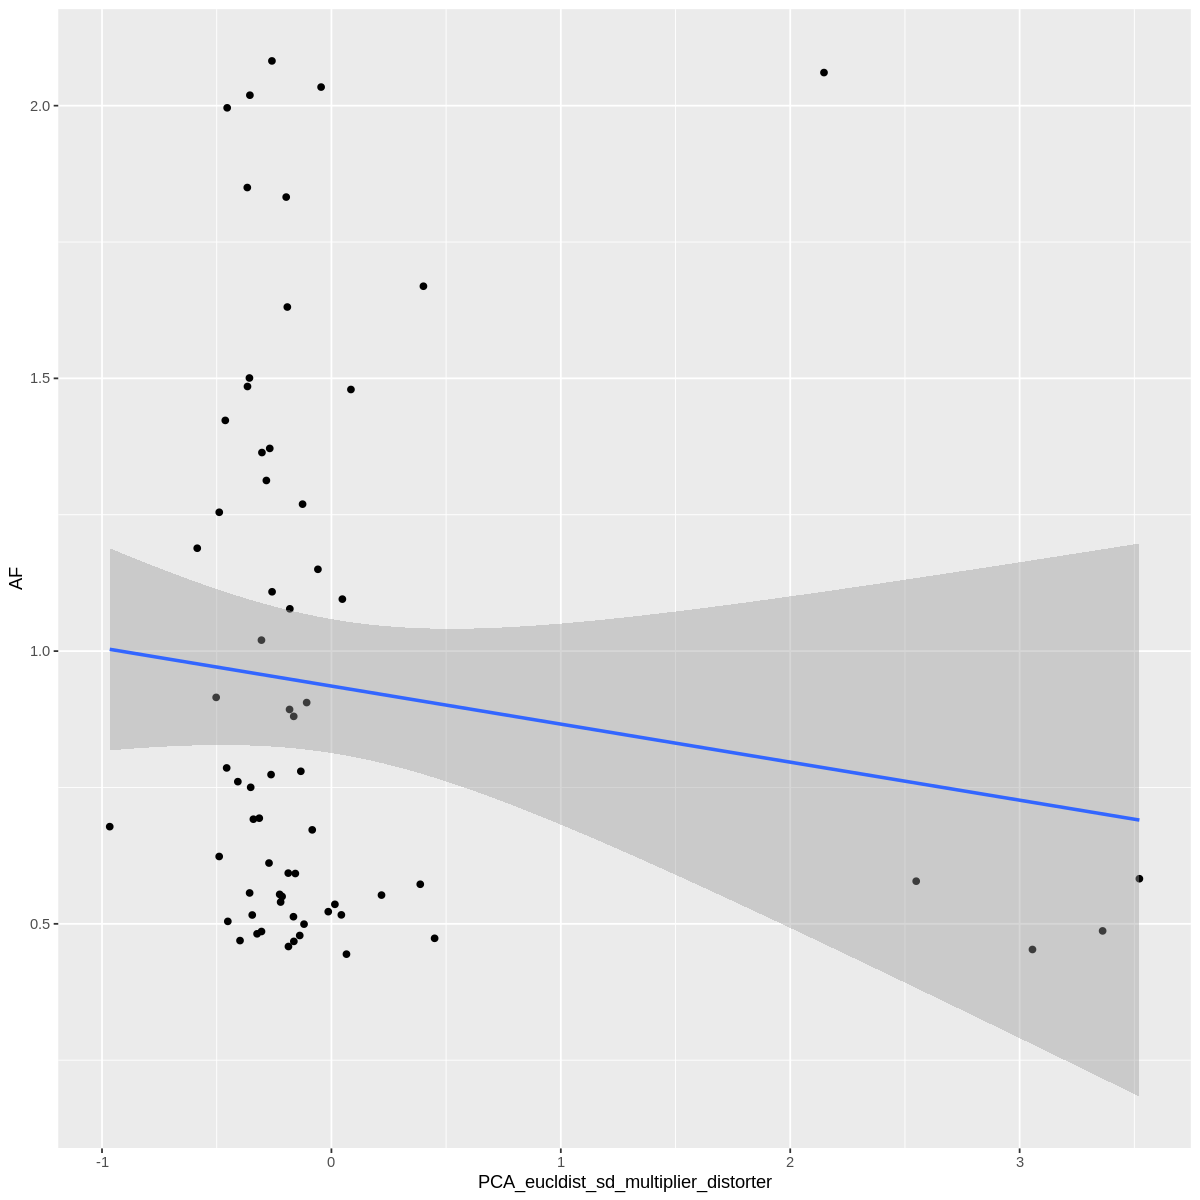

`geom_smooth()` using formula = 'y ~ x'


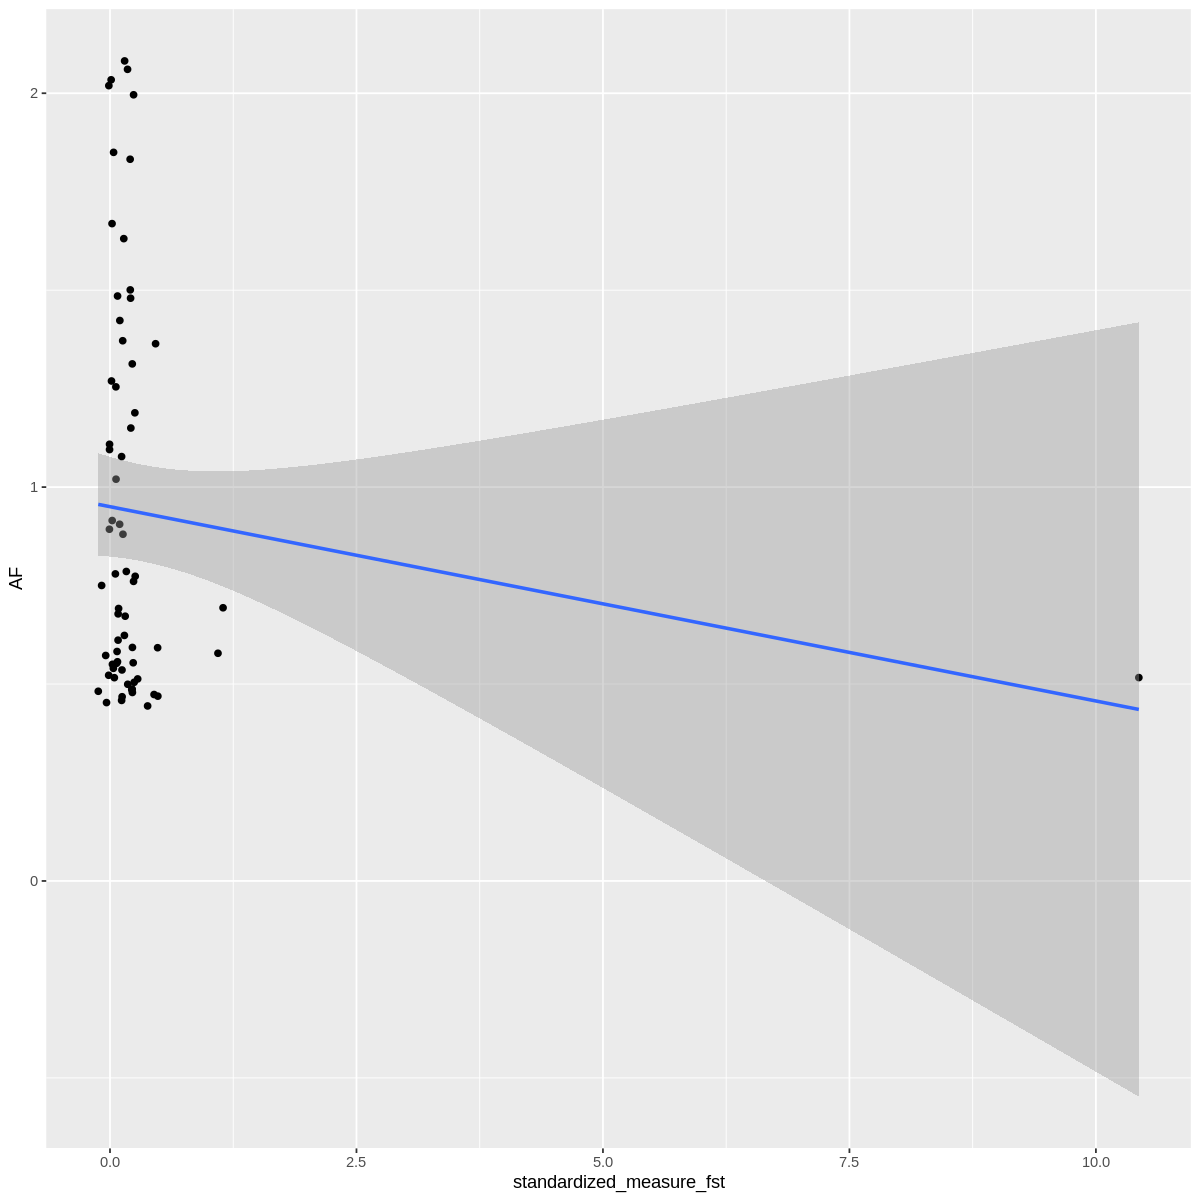

`geom_smooth()` using formula = 'y ~ x'


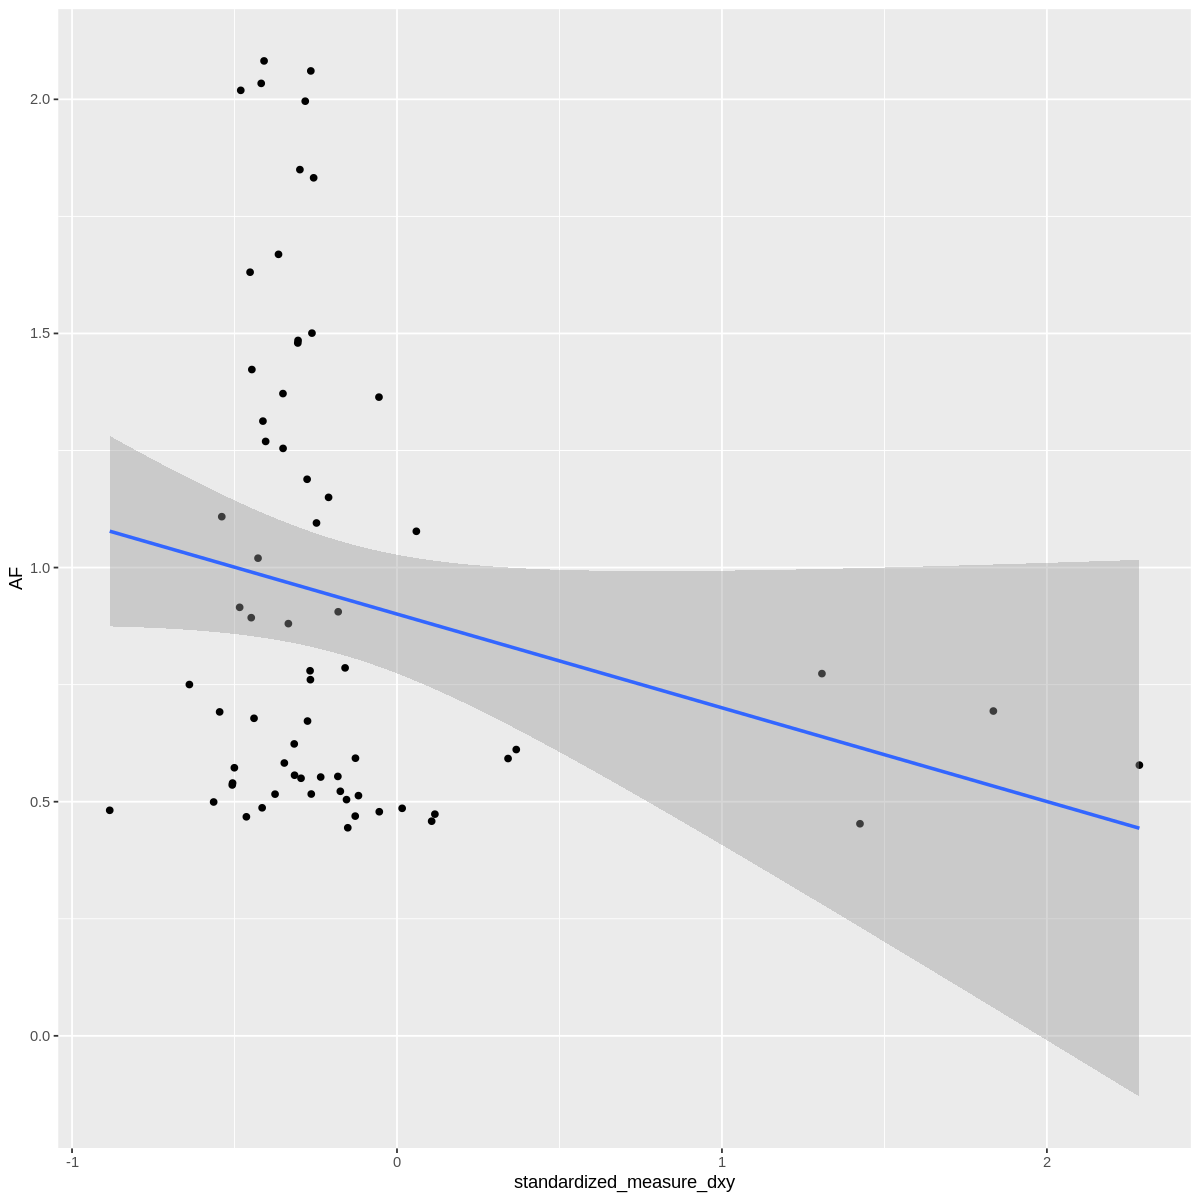

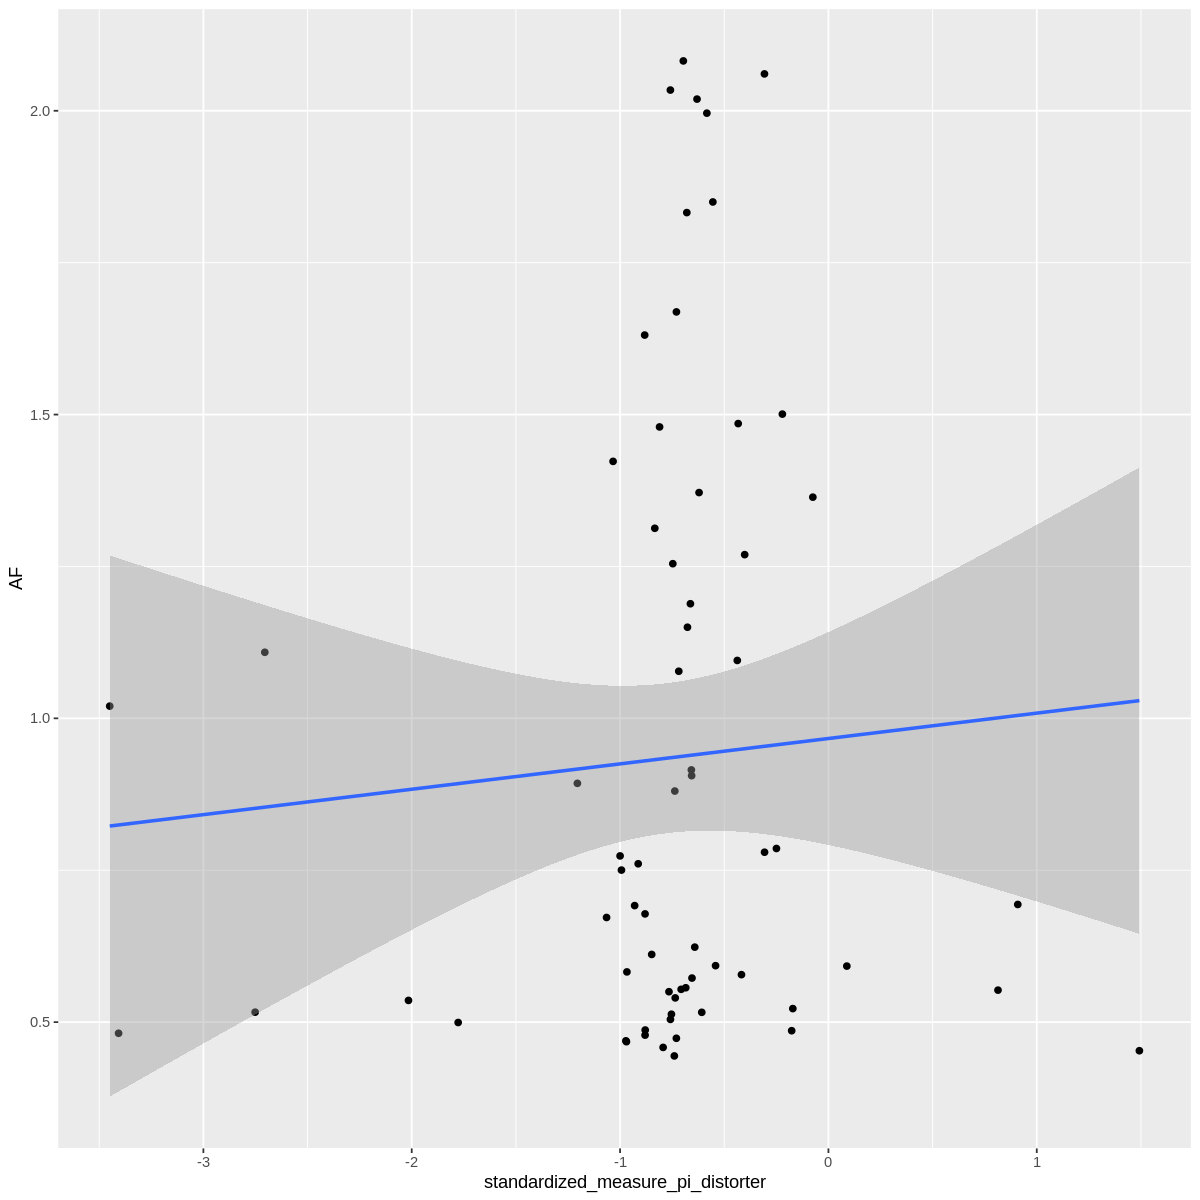

In [449]:
ggplot(clustering_subset, aes(PCA_eucldist_sd_multiplier_distorter, AF))+
geom_point()+geom_smooth(method="lm")

ggplot(clustering_subset, aes(standardized_measure_fst, AF))+
geom_point()+geom_smooth(method="lm")

ggplot(clustering_subset, aes(standardized_measure_dxy, AF))+
geom_point()+geom_smooth(method="lm")

ggplot(clustering_subset, aes(standardized_measure_pi_distorter, AF))+
geom_point()+geom_smooth(method="lm")

In [450]:


classify_values=function(x){
    # to group the TRD regions, I am classifying them by whether they are average or strong
    if(x >= 1){
        return("high")
    }
    if(x <= -1){
        return("weak")
    }
    return("average")
}
l_classify_values=function(x){
    return(unlist(lapply(x, classify_values)))
}

clustering_subset%>%
mutate_all(~ l_classify_values(.))%>%
group_by_all()%>%summarize(n=n())%>%arrange(-n)

`summarise()` has grouped output by 'AF', 'PCA_eucldist_sd_multiplier_distorter', 'IBS_eucldist_sd_multiplier_distorter',
'PCA_eucldist_sd_multiplier_other', 'IBS_eucldist_sd_multiplier_other', 'standardized_measure_pi_distorter',
'standardized_measure_pi_other', 'standardized_measure_fst', 'standardized_measure_dxy', 'LD_sd_multi_2'. You can override using
the `.groups` argument.


AF,PCA_eucldist_sd_multiplier_distorter,IBS_eucldist_sd_multiplier_distorter,PCA_eucldist_sd_multiplier_other,IBS_eucldist_sd_multiplier_other,standardized_measure_pi_distorter,standardized_measure_pi_other,standardized_measure_fst,standardized_measure_dxy,LD_sd_multi_2,TD_sd_multi,n
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
high,average,average,average,average,average,average,average,average,average,average,10
average,average,average,average,average,average,average,average,average,average,average,8
average,average,average,average,average,average,weak,average,average,average,average,7
average,average,average,average,average,average,average,average,average,weak,average,4
high,average,average,average,average,average,weak,average,average,average,average,4
high,average,average,average,average,average,weak,average,average,weak,average,3
average,average,average,average,average,weak,average,average,average,average,average,2
average,average,average,average,weak,average,average,average,average,average,average,2
high,average,average,average,average,average,average,average,average,weak,average,2


In [451]:
head(clustering_subset_classified<-clustering_subset%>%
mutate_all(~ l_classify_values(.)))

library(tidyverse)


# Function to compute co-occurrence
count_cooccurrence <- function(data, cols) {
  data %>%
    group_by(across(all_of(cols))) %>%
    summarise(count = n(), .groups = 'drop') %>%
    arrange(-count)
}

# Compute co-occurrence for all combinations of columns
results_list <- lapply(2:length(clustering_subset_classified), function(n) {
  combn(names(clustering_subset_classified), n, FUN = function(cols) {
    count_cooccurrence(clustering_subset_classified, cols)
  }, simplify = FALSE)
})

# Flatten the list of results
results <- do.call(c, results_list)

# Combine all results into a single tibble
cooccurrence_results <- bind_rows(results, .id = 'combination')

print(cooccurrence_results)


AF,PCA_eucldist_sd_multiplier_distorter,IBS_eucldist_sd_multiplier_distorter,PCA_eucldist_sd_multiplier_other,IBS_eucldist_sd_multiplier_other,standardized_measure_pi_distorter,standardized_measure_pi_other,standardized_measure_fst,standardized_measure_dxy,LD_sd_multi_2,TD_sd_multi
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
average,average,average,average,average,average,high,average,average,weak,average
average,average,average,average,average,average,average,average,average,average,average
average,average,average,average,average,average,average,average,average,weak,average
average,average,average,average,average,average,average,average,average,weak,average
average,average,average,high,average,average,average,average,average,average,average
high,average,average,average,average,weak,high,average,average,average,average


# A tibble: 31,909 x 13
   combina~1 AF    PCA_e~2 count IBS_e~3 PCA_e~4 IBS_e~5 stand~6 stand~7 stand~8
   <chr>     <chr> <chr>   <int> <chr>   <chr>   <chr>   <chr>   <chr>   <chr>  
 1 1         aver~ average    38 NA      NA      NA      NA      NA      NA     
 2 1         high  average    23 NA      NA      NA      NA      NA      NA     
 3 1         aver~ high        4 NA      NA      NA      NA      NA      NA     
 4 1         high  high        1 NA      NA      NA      NA      NA      NA     
 5 2         aver~ NA         36 average NA      NA      NA      NA      NA     
 6 2         high  NA         22 average NA      NA      NA      NA      NA     
 7 2         aver~ NA          5 high    NA      NA      NA      NA      NA     
 8 2         high  NA          2 high    NA      NA      NA      NA      NA     
 9 2         aver~ NA          1 weak    NA      NA      NA      NA      NA     
10 3         aver~ NA         37 NA      average NA      NA      NA      NA     
# ..

In [361]:
summary(clustering_subset)

       AF         PCA_eucldist_sd_multiplier_1 IBS_eucldist_sd_multiplier_1
 Min.   :0.4444   Min.   :-1.004128            Min.   :-1.406601           
 1st Qu.:0.5256   1st Qu.:-0.363915            1st Qu.:-0.361343           
 Median :0.7219   Median :-0.247153            Median :-0.005267           
 Mean   :0.9501   Mean   :-0.001435            Mean   : 0.209846           
 3rd Qu.:1.3020   3rd Qu.:-0.050331            3rd Qu.: 0.555436           
 Max.   :2.0820   Max.   : 4.219323            Max.   : 5.330618           
 PCA_eucldist_sd_multiplier_2 IBS_eucldist_sd_multiplier_2
 Min.   :-0.65593             Min.   :-1.400323           
 1st Qu.:-0.37976             1st Qu.:-0.289779           
 Median :-0.23705             Median : 0.007425           
 Mean   : 0.02776             Mean   : 0.225127           
 3rd Qu.:-0.08883             3rd Qu.: 0.570823           
 Max.   : 3.68647             Max.   : 5.320891           
 standardized_measure_pi_distorter standardized_measure

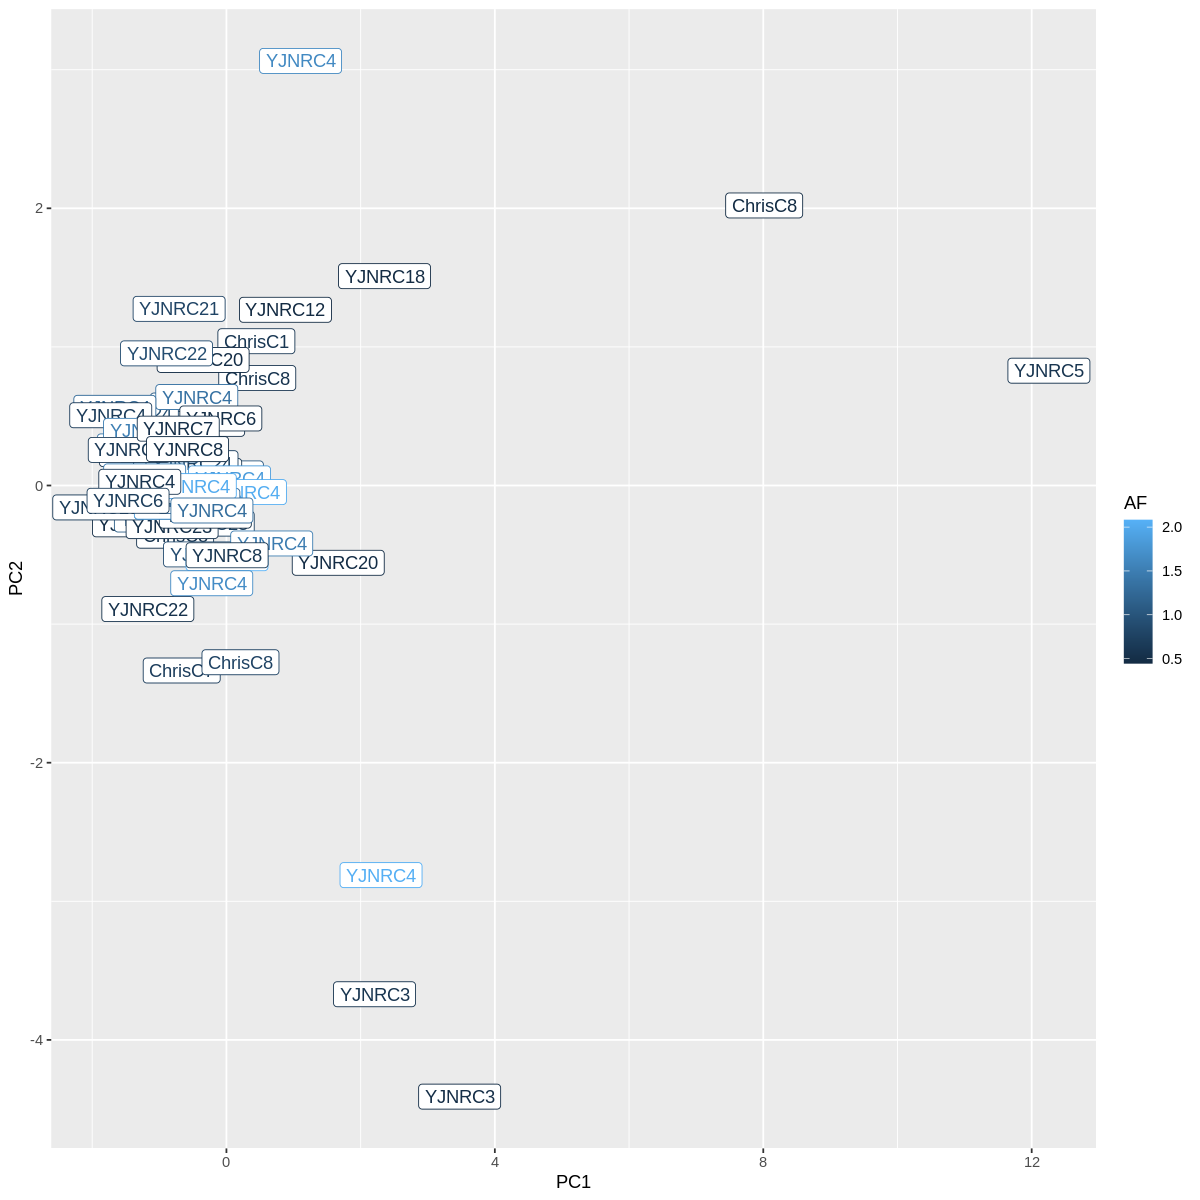

In [362]:
pca_df<-bind_cols(clustering_subset,as.data.frame(prcomp(select(clustering_subset, -AF))$x))
pca_df<-bind_cols(pca_df, data.table(row=OneTable_rows_in_clustering_subset))
pca_df<-left_join(pca_df, mutate(One_Table, row=row_number())%>%select(cross,ID,row), by="row")
ggplot(pca_df,
      aes(PC1,PC2,color=AF))+
geom_point()+geom_label(mapping=aes(label=cross))

In [397]:
saveRDS(pca_df, "~/data/trd/genomic_signals_pca.RDS")

In [363]:
cluster_transposed<-t(as.data.frame(select(clustering_subset, -AF)))
colnames(cluster_transposed)<-1:ncol(cluster_transposed)

Warning message:
"Removed 2 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_label_repel()`)."


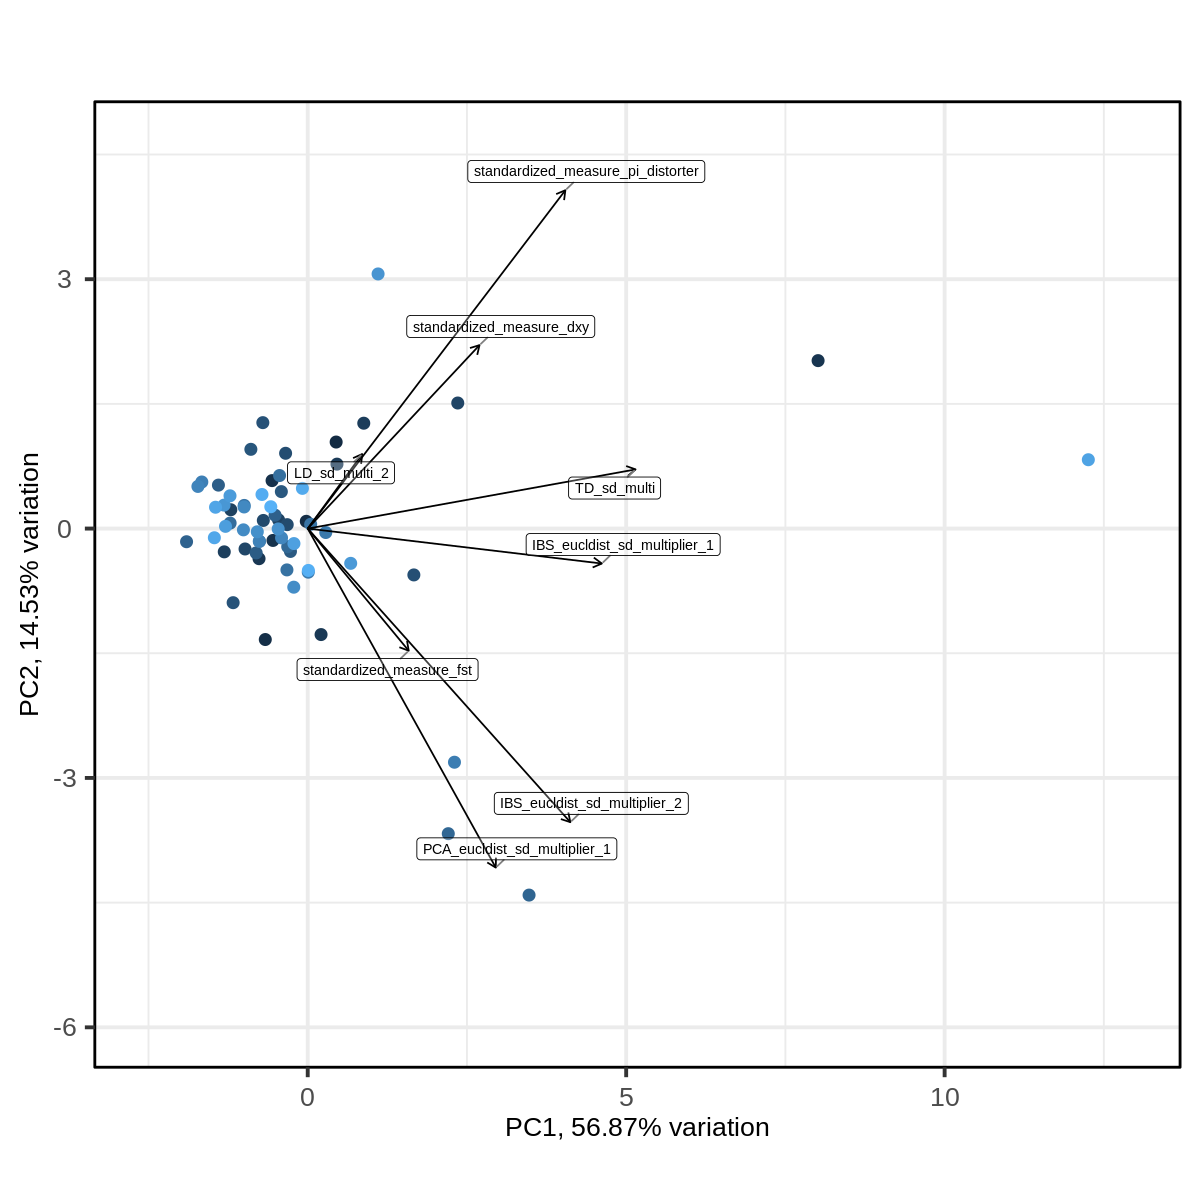

In [364]:
library(PCAtools)
#metadata<-data.frame(row.names = colnames(cluster_transposed), AF=pull(clustering_subset, AF))
p <- pca(cluster_transposed)
biplot(p, showLoadings = TRUE, lab = NULL, showLoadingsNames=TRUE, ntopLoadings=10)


In [365]:
cor(clustering_subset)

,AF,PCA_eucldist_sd_multiplier_1,IBS_eucldist_sd_multiplier_1,PCA_eucldist_sd_multiplier_2,IBS_eucldist_sd_multiplier_2,standardized_measure_pi_distorter,standardized_measure_pi_other,standardized_measure_fst,standardized_measure_dxy,LD_sd_multi_2,TD_sd_multi
AF,1.00000000,-0.10906265,-0.04403798,-0.07718036,-0.01056465,-0.1689822,-0.09586431,-0.3320374,-0.2076530,-0.08301325,-0.1056499
PCA_eucldist_sd_multiplier_1,-0.10906265,1.00000000,0.62366100,0.73278598,0.50256876,0.4127744,0.25081964,0.2783354,0.3687918,0.03827455,0.6073248
IBS_eucldist_sd_multiplier_1,-0.04403798,0.62366100,1.00000000,0.43194926,0.67499892,0.6382728,0.53783697,0.2992176,0.6344848,0.24619598,0.8547213
PCA_eucldist_sd_multiplier_2,-0.07718036,0.73278598,0.43194926,1.00000000,0.60522113,0.2306742,0.14153915,0.2681471,0.2660881,0.01296708,0.4599626
IBS_eucldist_sd_multiplier_2,-0.01056465,0.50256876,0.67499892,0.60522113,1.00000000,0.4518878,0.34743685,0.3230000,0.5658109,0.24905102,0.7025542
standardized_measure_pi_distorter,-0.16898221,0.41277440,0.63827277,0.23067420,0.45188783,1.0000000,0.68377464,0.1649400,0.7793886,0.32016127,0.7756423
standardized_measure_pi_other,-0.09586431,0.25081964,0.53783697,0.14153915,0.34743685,0.6837746,1.00000000,0.2362858,0.7866811,0.10587911,0.6299899
standardized_measure_fst,-0.33203739,0.27833535,0.29921756,0.26814713,0.32300005,0.1649400,0.23628581,1.0000000,0.4042347,-0.04472670,0.2781958
standardized_measure_dxy,-0.20765300,0.36879180,0.63448477,0.26608808,0.56581089,0.7793886,0.78668113,0.4042347,1.0000000,0.21299471,0.7463003
LD_sd_multi_2,-0.08301325,0.03827455,0.24619598,0.01296708,0.24905102,0.3201613,0.10587911,-0.0447267,0.2129947,1.00000000,0.3437618


In [366]:
# GO terms

GO_files<-list.files("/home/jnrunge/data/trd/GO_data", full.names = TRUE, pattern="GOdata.RDS$")

# across all samples, I am aggregating all data on "over-represented" (by simple division) GO terms across samples, summarize the frequencies, and then test again against the global distribution.

GO_terms<-bind_rows(lapply(GO_files, readRDS))%>%group_by(GO, Freq, Other)%>%summarize(Freq_TRD=sum(Freq_location),
                                                               Other_TRD=sum(Other_location))%>%arrange(GO)%>%ungroup()
GO_terms<-filter(GO_terms,(Freq_TRD/Other_TRD) > (Freq/Other))
nrow(GO_terms)

GO_terms<-mutate(GO_terms, pChisq=NA)

for(i in 1:nrow(GO_terms)){
        col1<-slice(GO_terms, i)%>%select(Freq_TRD,Other_TRD)%>%t()
        col2<-slice(GO_terms, i)%>%select(Freq,Other)%>%t()
        colnames(col1)<-"col1"
        colnames(col2)<-"col2"
        cols<-bind_cols(col1,col2)
        p_chi<-chisq.test(cols, simulate.p.value = TRUE, B = round((1/(0.05/nrow(GO_terms)))*2))$p.value # 2x as many replicates as would be needed to reach corrected significance if possible
        GO_terms<-mutate(GO_terms, pChisq=ifelse(row_number()==i,
                                                p_chi,
                                                pChisq))
    }

`summarise()` has grouped output by 'GO', 'Freq'. You can override using the `.groups` argument.


[1] 3792

In [ ]:
library(rrvgo)

GO_terms_enriched<-filter(GO_terms, pChisq<(0.05/nrow(GO_terms)))

    simMatrix <- calculateSimMatrix(pull(GO_terms_enriched, GO),
                                    orgdb="org.Sc.sgd.db", # yeast Sc 
                                    ont="BP", # biological processes; could also use CC or MF
                                    method="Rel")

    scores <- setNames(-log10(pull(GO_terms_enriched, pChisq)), pull(GO_terms_enriched, GO))
    reducedTerms <- reduceSimMatrix(simMatrix,
                                    scores,
                                    threshold=0.7,
                                    orgdb="org.Sc.sgd.db")


treemapPlot(reducedTerms)
wordcloudPlot(reducedTerms, min.freq=1, colors="black")

In [367]:
One_Table<-filter(One_Table, !is.na(lengthBp))

In [368]:
# missing values

missing_overview <- One_Table %>%
  group_by(cross) %>%
  summarise(across(everything(), ~sum(is.na(.x)), .names = "missing_in_{.col}"))

missing_long <- missing_overview %>%
  tidyr::gather(column, missing_count, -cross)
missing_ordered <- missing_long %>% group_by(column)%>%summarize(missing_count=sum(missing_count))%>%
  filter(missing_count > 0) %>%
  arrange(desc(missing_count))
missing_ordered %>%
  rowwise() %>%
  mutate(description = paste("Column", column, "is missing in", missing_count, "regions.")) %>%
  pull(description) %>%
  print()


 [1] "Column missing_in_CONTR_VictorSV is missing in 83 regions."                   
 [2] "Column missing_in_CPG_Syri is missing in 83 regions."                         
 [3] "Column missing_in_CPL_Syri is missing in 83 regions."                         
 [4] "Column missing_in_DEL_Syri is missing in 83 regions."                         
 [5] "Column missing_in_DEL_VictorSV is missing in 83 regions."                     
 [6] "Column missing_in_DUP_Syri is missing in 83 regions."                         
 [7] "Column missing_in_DUP_VictorSV is missing in 83 regions."                     
 [8] "Column missing_in_HDR_Syri is missing in 83 regions."                         
 [9] "Column missing_in_INS_Syri is missing in 83 regions."                         
[10] "Column missing_in_INS_VictorSV is missing in 83 regions."                     
[11] "Column missing_in_INVDP_Syri is missing in 83 regions."                       
[12] "Column missing_in_INVTR_Syri is missing in 83 regions."    

In [369]:
filter(One_Table, is.na(sum_value_pi_distorter))

ID,lengthSNPs,chr,global_start,global_end,lengthBp,cross,start,end,PCA_eucldist_quantile_1,...,INVDP_Syri,TDM_Syri,TRANS_Syri,INVTR_Syri,TRA_VictorSV,CONTR_VictorSV,LD_sd_multi_1,LD_sd_multi_2,TD_sd_multi,TD_ecdf
<dbl>,<int>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,206,chromosome14,9398197,9591625,193428,ChrisC1,224256,417684,0.31945691,...,NA,NA,NA,NA,NA,NA,2.81184301,-0.77865179,-0.34104881,0.3813034
13,815,chromosome15,10015850,10580994,565144,ChrisC1,66814,631958,0.65739578,...,NA,NA,NA,NA,NA,NA,2.14549024,-1.21278128,-0.05943522,0.5518305
14,235,chromosome16,11462227,11683028,220801,ChrisC1,429498,650299,0.47568634,...,NA,NA,NA,NA,NA,NA,1.34211285,-1.73618245,-0.02183141,0.5731611
4,2603,chromosome5,2944974,3258307,313333,ChrisC3,65081,378414,0.71577247,...,NA,NA,NA,NA,NA,NA,2.60666907,-0.91232281,-0.35851533,0.3705288
11,901,chromosome11,6549018,6720267,171249,ChrisC3,18001,189250,0.15993780,...,NA,NA,NA,NA,NA,NA,1.64442405,-1.53922640,0.43095539,0.7729695
2,396,chromosome9,5365795,5756812,391017,ChrisC4,20953,411970,0.77905377,...,0.001892501,0.0003785002,0.0008746423,0.0000000000,0.0000000,0,3.60378028,-0.26270387,0.05381041,0.6140153
5,106,chromosome15,10177427,10359255,181828,ChrisC5,278604,460432,0.41096956,...,NA,NA,NA,NA,NA,NA,1.57255134,-1.58605154,-0.15075510,0.4963356
7,1227,chromosome11,6558616,6697564,138948,ChrisC7,29994,168942,0.73790298,...,NA,NA,NA,NA,NA,NA,1.71562596,-1.49283828,0.40615472,0.7655147
9,957,chromosome13,8943534,9065780,122246,ChrisC7,683976,806222,0.61271607,...,NA,NA,NA,NA,NA,NA,1.80323391,-1.43576162,0.25446853,0.7116587


In [477]:
fwrite(One_Table, "03_OneTable.csv.gz")

In [389]:
SV_data_org<-SV_data

In [402]:
cross_render<-"ChrisC1"
cross<-cross_render
rmarkdown::render("03_RegionReportTemplate.Rmd", params = 
                  list(cross=cross),
                  output_file = paste0("~/TRD/03_GenomicSignals/PDF_reports/",cross, '.HTML'), 
                 )



processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/ChrisC1.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/ChrisC1.HTML



In [404]:
 # the render function seems to overwrite variables...
for(cross_render in select(One_Table, cross)%>%distinct()%>%pull(cross))
    {
    #if(nrow(filter(SV_data_org, cross==cross_render))==0){
    #    next
    #}
    cross<-cross_render
    print(cross_render)
    rmarkdown::render("03_RegionReportTemplate.Rmd", params = 
                  list(cross=cross),
                  output_file = paste0("~/TRD/03_GenomicSignals/PDF_reports/",cross, '.HTML'), 
                 )
}



[1] "ChrisC1"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/ChrisC1.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/ChrisC1.HTML



[1] "ChrisC3"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/ChrisC3.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/ChrisC3.HTML



[1] "ChrisC4"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/ChrisC4.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/ChrisC4.HTML



[1] "ChrisC5"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/ChrisC5.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/ChrisC5.HTML



[1] "ChrisC7"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/ChrisC7.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/ChrisC7.HTML



[1] "ChrisC8"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/ChrisC8.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/ChrisC8.HTML



[1] "YJNRC12"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/YJNRC12.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/YJNRC12.HTML



[1] "YJNRC14"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/YJNRC14.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/YJNRC14.HTML



[1] "YJNRC15"




processing file: 03_RegionReportTemplate.Rmd



                                                                                                                      (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                    (unnamed-chunk-15)                    (unnamed-chunk-16)                    (unnamed-chunk-17)                    (unnamed-chunk-18)                    (unnamed-chunk-19)                    (unnamed-chunk-20)                    (unnamed-chunk-21)                    (unnamed-chunk-22)


output file: 03_RegionReportTemplate.knit.md




/home/jnrunge/anaconda3/envs/JupyteR4/bin/pandoc +RTS -K512m -RTS 03_RegionReportTemplate.knit.md --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output /home/jnrunge/TRD/03_GenomicSignals/PDF_reports/YJNRC15.HTML --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/bookdown/rmarkdown/lua/custom-environment.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/pagebreak.lua --lua-filter /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmarkdown/rmarkdown/lua/latex-div.lua --embed-resources --standalone --wrap preserve --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' --variable 'html_clean:true' --variable 'lightbox:true' --variable 'thumbnails:true' --variable 'gallery:true' --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 2 --template /home/jnrunge/anaconda3/envs/JupyteR4/lib/R/library/rmdformats/templates/template.html --highli


Output created: ~/TRD/03_GenomicSignals/PDF_reports/YJNRC15.HTML



[1] "YJNRC17"




processing file: 03_RegionReportTemplate.Rmd



  |...................................                |  68%                    (unnamed-chunk-1)                     (unnamed-chunk-2)                     (unnamed-chunk-3)                     (unnamed-chunk-4)                     (unnamed-chunk-5)                     (unnamed-chunk-6)                     (unnamed-chunk-7)                     (unnamed-chunk-8)                     (unnamed-chunk-9)                     (unnamed-chunk-10)                    (unnamed-chunk-11)                    (unnamed-chunk-12)                    (unnamed-chunk-13)                    (unnamed-chunk-14)                   

Quitting from lines 278-300 (03_RegionReportTemplate.Rmd) 



ERROR: Error in gzfile(file, "rb"): cannot open the connection
